<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
import tensorflow as tf
import tensorflow_addons as tfa
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/allDataCLAHE', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 11586 files [04:25, 43.66 files/s] 


In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=5)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)

In [ ]:
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [ ]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.38272, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.38272 to 0.56674, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56674 to 0.59654, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.59654 to 0.62721, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62721

Epoch 6: val_accuracy improved from 0.62721 to 0.63585, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63585

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.63585

Epoch 9: val_accuracy did not improve from 0.63585
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

LOSS:	1.1358280181884766 	 ACCURACY:	0.6332613229751587
[1.1358280181884766, 0.6332613229751587]



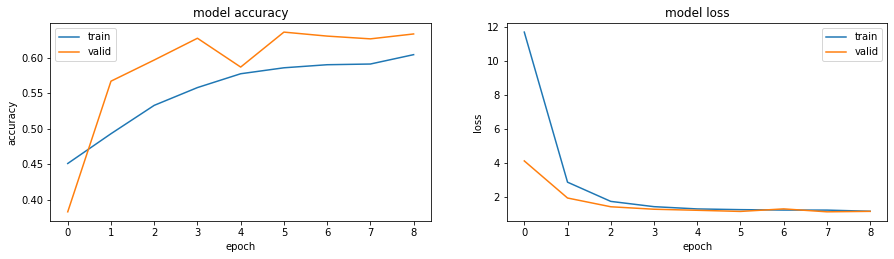


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.52181, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52181 to 0.52657, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52657 to 0.53952, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53952 to 0.54082, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54082 to 0.54773, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54773 to 0.56199, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56199 to 0.57495, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57495 to 0.58575, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.58575

Epoch 10: val_accuracy improved from 0.58575 to 0.59914, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59914 to 0.59957, saving mo

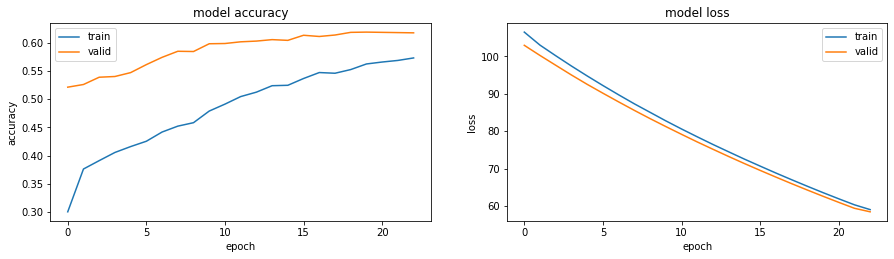


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.27300, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.27300 to 0.46220, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.46220 to 0.49244, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.49244 to 0.49417, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.49417

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 6: val_accuracy did not improve from 0.49417

Epoch 7: val_accuracy did not improve from 0.49417
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 12.4339 - accuracy: 0.4903

LOSS:	12.433897972106934 	 ACCURACY:	0.49028077721595764
[12.433897972106934, 0.49028077721595764]



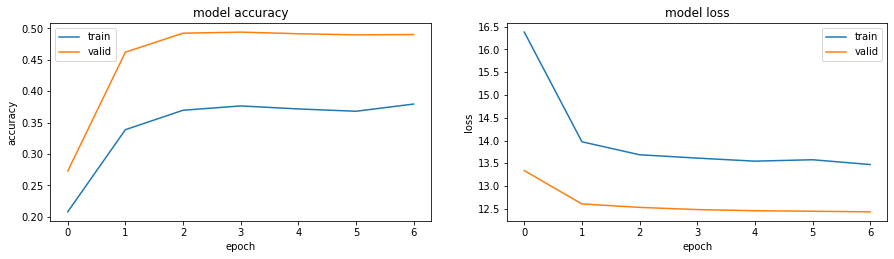


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.56069, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.56069

Epoch 3: val_accuracy improved from 0.56069 to 0.57667, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.57667 to 0.59179, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59179 to 0.59957, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.59957

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.59957

Epoch 8: val_accuracy improved from 0.59957 to 0.60734, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.60734

Epoch 10: val_accuracy improved from 0.60734 to 0.60864, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.60864

Epoch 12: val_acc

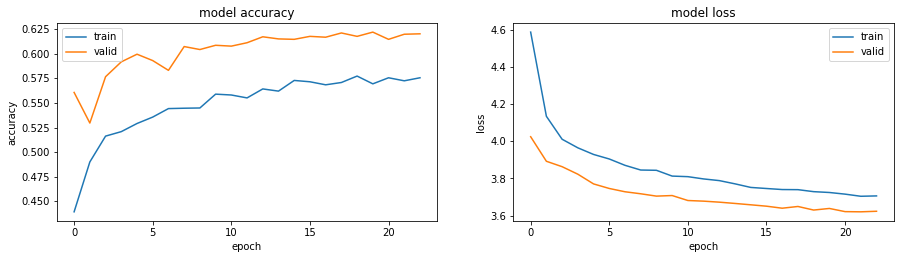


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.61037, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.61037 to 0.62030, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.62030

Epoch 4: val_accuracy improved from 0.62030 to 0.62203, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62203

Epoch 6: val_accuracy improved from 0.62203 to 0.63240, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63240

Epoch 8: val_accuracy improved from 0.63240 to 0.64233, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.64233

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.64233

Epoch 11: val_accuracy did not improve from 0.64233
Epoch 11: early stopping
73/73 [============

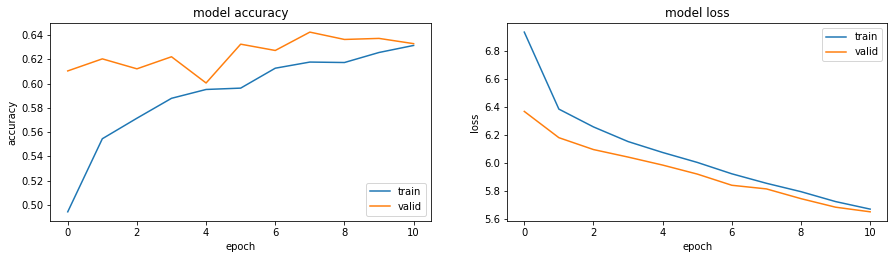




Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.53650, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53650 to 0.54644, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54644 to 0.54687, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54687 to 0.55896, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55896 to 0.57711, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.57711 to 0.59093, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.59093 to 0.59395, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.59395 to 0.59482, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.59482

Epoch 10: val_accuracy improved from 0.59482 to 0.60734, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.60734 to 0.60821, saving 

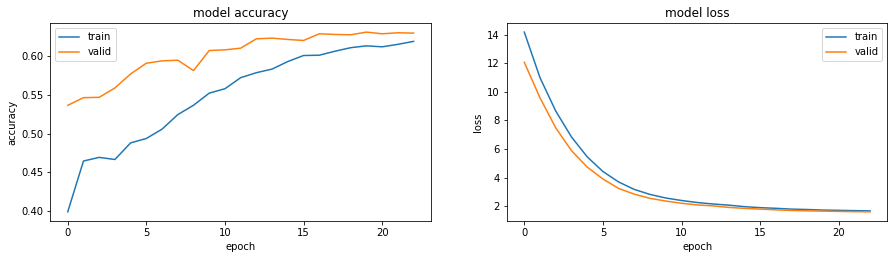


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6333

Epoch 1: val_accuracy improved from -inf to 0.62808, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.62808 to 0.63153, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.63153 to 0.63888, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.63888

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.63888

Epoch 6: val_accuracy improved from 0.63888 to 0.63974, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.63974 to 0.64406, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.64406

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.64406

Epoch 10: val_accuracy did not improve from 0.64406
Epoch 10: early stopp

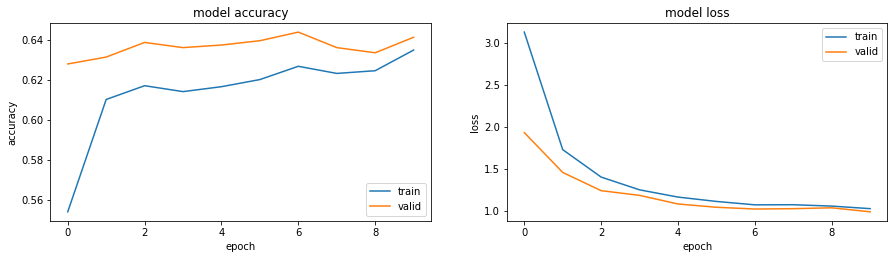


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.56587, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56587 to 0.61771, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61771 to 0.63024, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63024 to 0.63067, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63067

Epoch 6: val_accuracy improved from 0.63067 to 0.63844, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63844

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.63844

Epoch 9: val_accuracy improved from 0.63844 to 0.64060, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64060 to 0.64190, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.6419

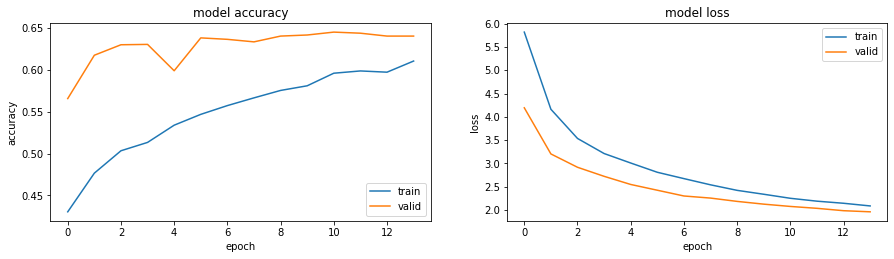


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 2.0e+00 7.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.51836, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51836 to 0.52225, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52225 to 0.52484, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.52484 to 0.52700, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.52700 to 0.52743, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.52743

Epoch 7: val_accuracy improved from 0.52743 to 0.52829, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.52829

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 9: val_accuracy did not improve from 0.52829

Epoch 10: val_accuracy did not improve from 0.52829
Epoch 10: early stopping
73/73 [==============================] - 0s 3ms/step 

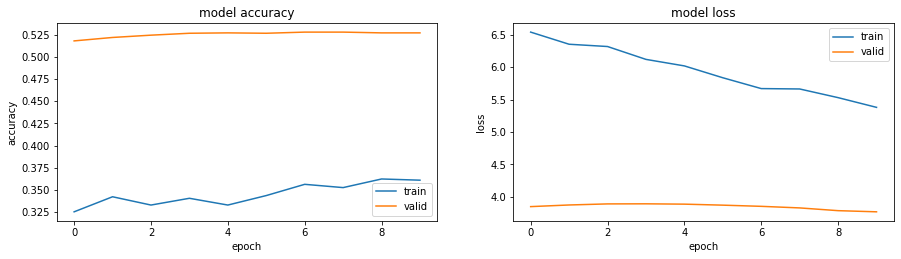


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.51836, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.51836

Epoch 3: val_accuracy improved from 0.51836 to 0.51965, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.51965

Epoch 5: val_accuracy improved from 0.51965 to 0.52700, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.52700

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.52700

Epoch 8: val_accuracy improved from 0.52700 to 0.53002, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53002 to 0.53132, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53132 to 0.53305, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.53305 to 0.53650, saving model 

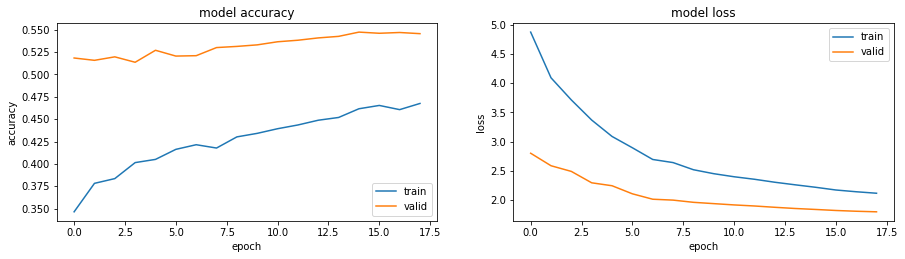


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.22030, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.22030 to 0.32009, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.32009 to 0.40130, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.40130 to 0.44233, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.44233 to 0.46998, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.46998 to 0.48251, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.48251 to 0.49330, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.49330 to 0.49719, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.49719 to 0.50454, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.50454 to 0.50670, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

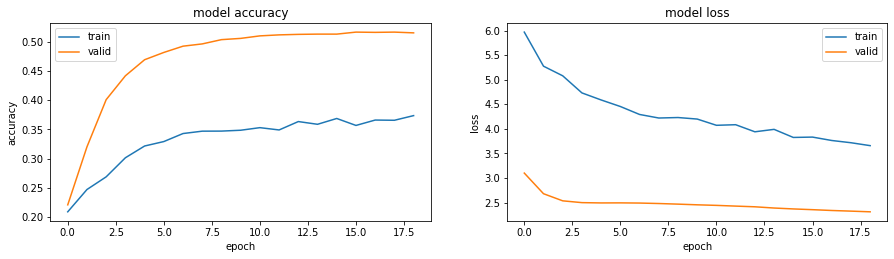


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.55119, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55119 to 0.61598, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61598 to 0.61771, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.61771

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.61771

Epoch 6: val_accuracy improved from 0.61771 to 0.62894, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62894

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.62894

Epoch 9: val_accuracy did not improve from 0.62894
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1055 - accurac

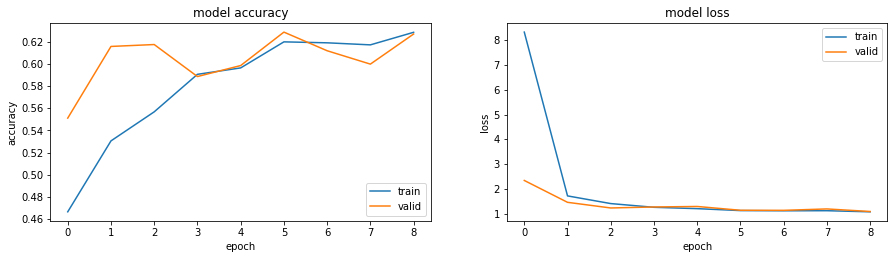


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.57063, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57063 to 0.61469, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61469 to 0.62765, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62765 to 0.63974, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63974 to 0.64665, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64665

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.64665

Epoch 8: val_accuracy did not improve from 0.64665
Epoch 8: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 3.0294 - accuracy: 0.6324

LOSS:	3.029386520385742 	 ACCURACY:	0.6323974132537842
[3.029386520385742, 0.63239741325378

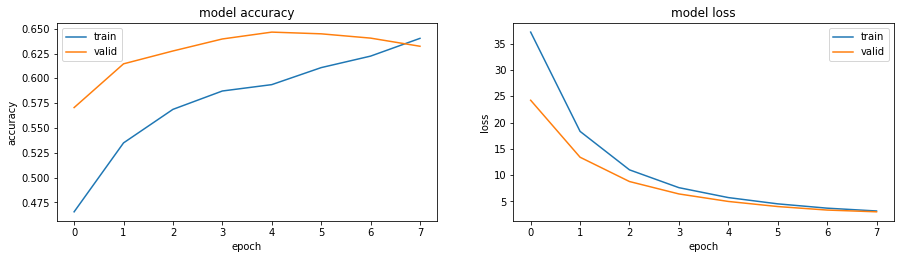


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.33866, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.33866 to 0.47387, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47387 to 0.50972, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.50972 to 0.51879, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.51879 to 0.52138, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.52138 to 0.52311, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52311 to 0.52484, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.52484

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.52484

Epoch 10: val_accuracy did not improve from 0.52484
Epoch 10: early stopping
73/73 [============

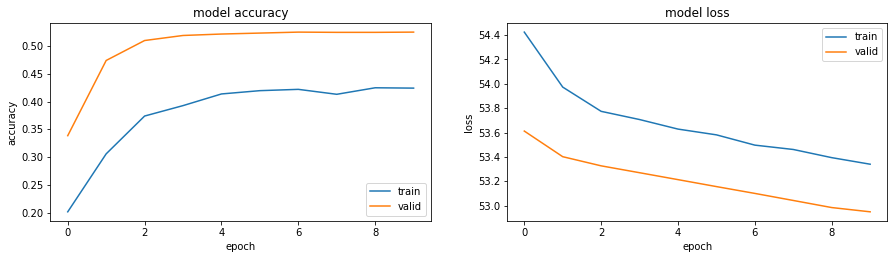


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.46566, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.46566 to 0.53261, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53261 to 0.53650, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53650 to 0.54168, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54168 to 0.54298, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54298 to 0.54341, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.54341

Epoch 8: val_accuracy improved from 0.54341 to 0.54428, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54428 to 0.54600, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54600 to 0.54730, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.54730 to 0.54773, saving mo

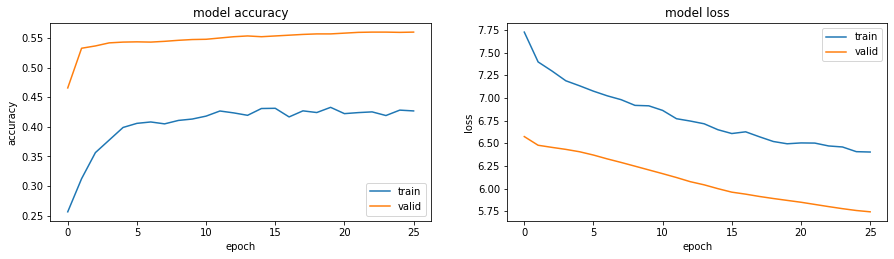


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.50540, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50540 to 0.51404, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.51404

Epoch 4: val_accuracy improved from 0.51404 to 0.54600, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54600 to 0.54644, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54644 to 0.55983, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55983 to 0.56156, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.56156 to 0.56933, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.56933 to 0.58056, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.58056 to 0.59654, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.59654

Epoch 12: val

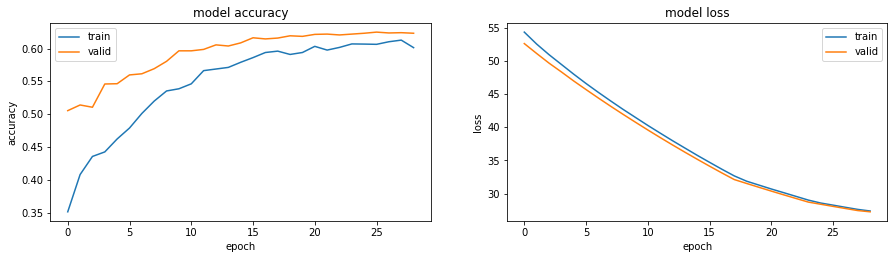


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.16156, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.16156 to 0.16631, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.16631 to 0.17624, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.17624 to 0.19136, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.19136 to 0.21296, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.21296 to 0.25616, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.25616 to 0.29762, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.29762 to 0.34730, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.34730 to 0.38920, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.38920 to 0.42721, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

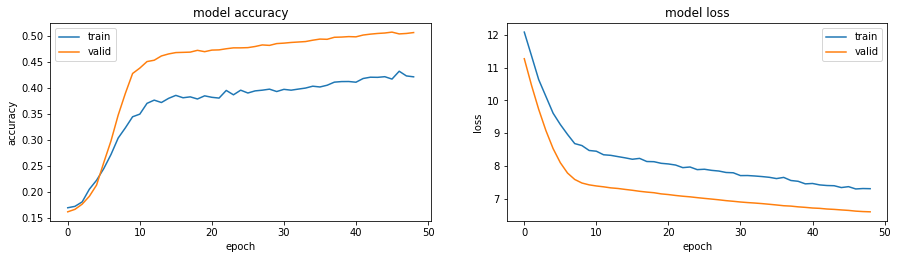


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.51533, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51533 to 0.52743, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52743 to 0.54816, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54816 to 0.55896, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55896 to 0.56890, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56890 to 0.57840, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57840 to 0.58359, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58359 to 0.58877, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58877 to 0.59050, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59050 to 0.60216, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

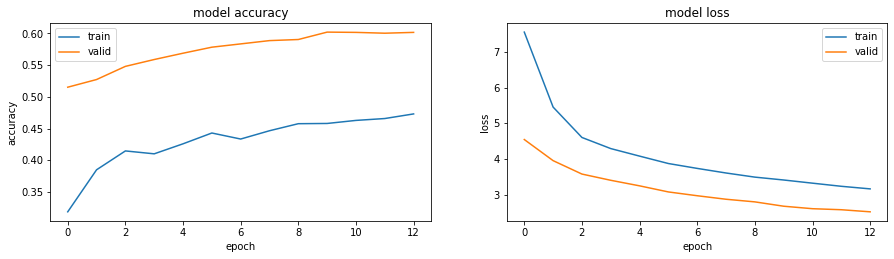


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.6415

Epoch 1: val_accuracy improved from -inf to 0.59050, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59050 to 0.61296, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61296 to 0.62808, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62808

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.62808

Epoch 6: val_accuracy improved from 0.62808 to 0.63067, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63067

Epoch 8: val_accuracy improved from 0.63067 to 0.63758, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63758

Epoch 10: val_accuracy improved from 0.63758 to 0.64233, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.64233 to 0.64622, saving model 

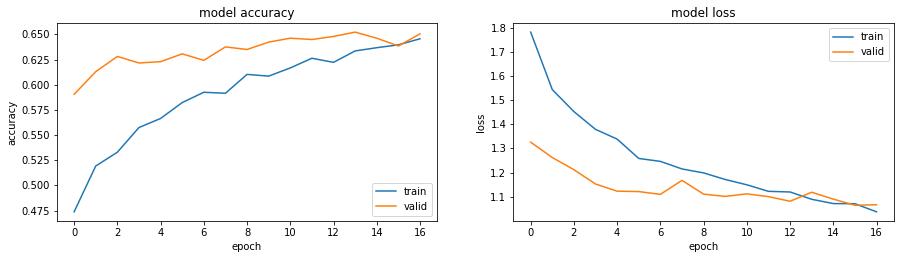


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.56285, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56285 to 0.59179, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59179 to 0.61512, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.61512 to 0.62635, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62635 to 0.63153, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.63153 to 0.63801, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63801

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.63801

Epoch 9: val_accuracy did not improve from 0.63801
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.0452 - accuracy: 0.6315

LOSS:	1.0452

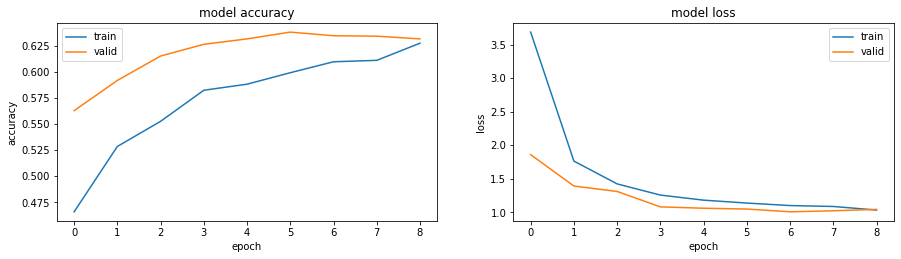


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.31317, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.31317 to 0.36760, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.36760 to 0.40950, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.40950 to 0.43931, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.43931 to 0.45961, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.45961 to 0.47819, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.47819 to 0.48985, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.48985 to 0.49633, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.49633 to 0.49978, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.49978 to 0.50281, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

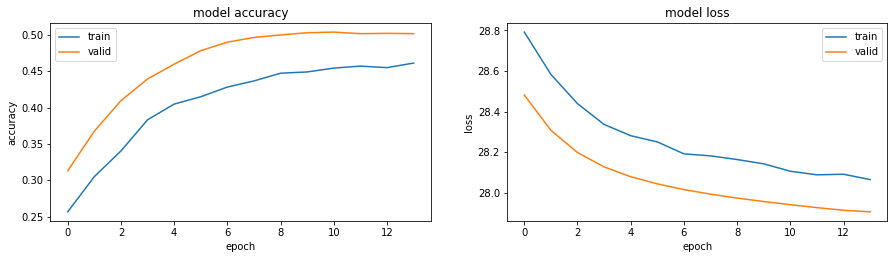


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.18272, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18272 to 0.21382, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.21382 to 0.25270, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.25270 to 0.29244, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.29244 to 0.34168, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.34168 to 0.38229, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.38229 to 0.41123, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.41123 to 0.43715, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.43715 to 0.46004, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.46004 to 0.47862, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

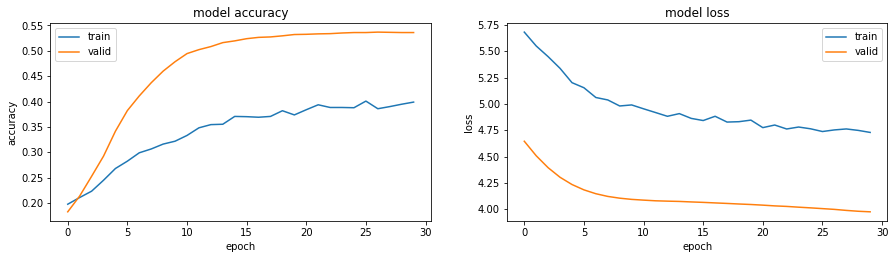


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.54341, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54341 to 0.54384, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54384 to 0.54557, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54557 to 0.55119, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55119 to 0.55983, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.55983 to 0.56501, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56501 to 0.57192, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57192 to 0.57927, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.57927 to 0.58488, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.58488 to 0.58531, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

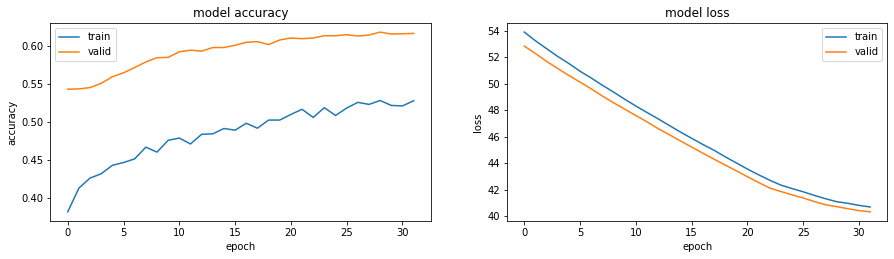


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.51317, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51317 to 0.51577, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.51577 to 0.53996, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53996 to 0.54860, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54860 to 0.55680, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.55680 to 0.55940, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55940 to 0.56803, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.56803 to 0.57408, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.57408 to 0.58013, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.58013

Epoch 11: val_accuracy improved from 0.58013 to 0.58877, saving mo

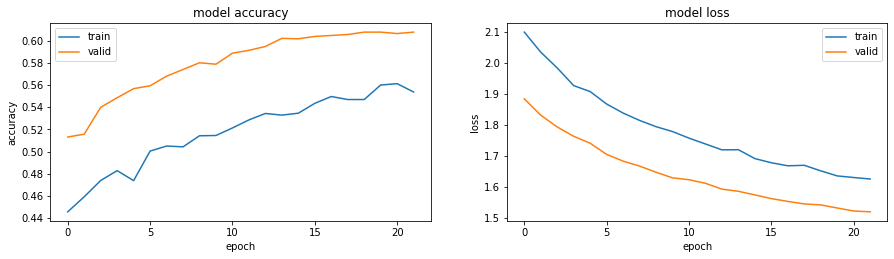


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.26911, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.26911 to 0.30670, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.30670 to 0.34773, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.34773 to 0.37451, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.37451 to 0.40043, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.40043 to 0.41685, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.41685 to 0.42721, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.42721 to 0.43369, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.43369 to 0.44449, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.44449 to 0.44579, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

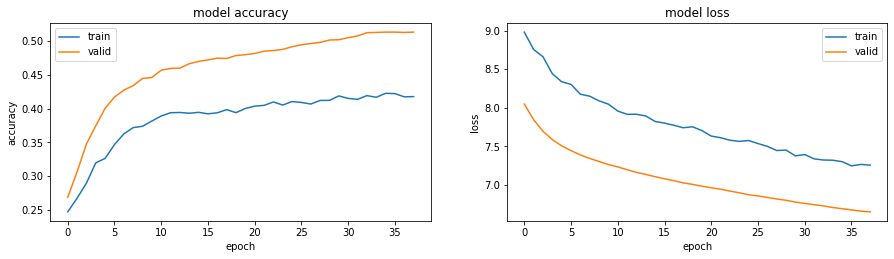


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.30454, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.30454 to 0.54514, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54514 to 0.55248, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.55248 to 0.55767, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55767 to 0.61857, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.61857

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.61857

Epoch 8: val_accuracy improved from 0.61857 to 0.62635, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.62635

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0

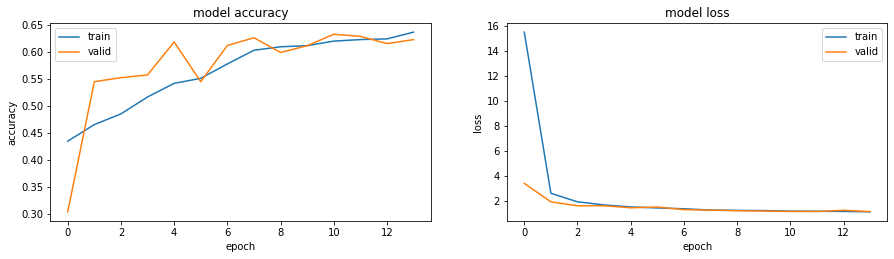


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.52873, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52873 to 0.53996, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53996 to 0.54989, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54989 to 0.55767, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55767 to 0.56371, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56371 to 0.57235, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57235 to 0.58315, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.58315

Epoch 9: val_accuracy improved from 0.58315 to 0.59050, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59050 to 0.59611, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59611 to 0.60173, saving mo

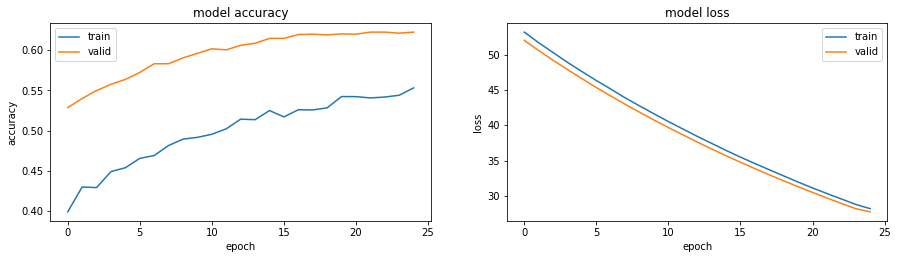


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.41814, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.41814 to 0.49935, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.49935 to 0.52700, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.52700 to 0.53218, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53218 to 0.53693, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53693 to 0.53780, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.53780 to 0.53823, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53823 to 0.53866, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.53866

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 10: val_accuracy did not improve from 0.53866

Epoch 11: val_a

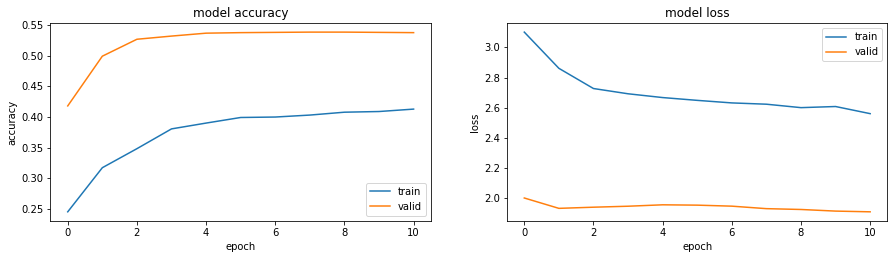


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.39395, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.39395 to 0.40173, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.40173 to 0.40778, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.40778 to 0.41685, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.41685 to 0.42333, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.42333 to 0.42721, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.42721 to 0.43499, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.43499 to 0.43974, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.43974 to 0.44320, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.44320 to 0.44449, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

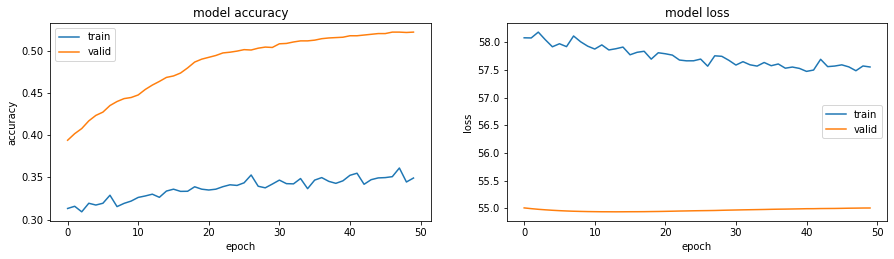


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.58661, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58661 to 0.61728, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61728 to 0.62635, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62635 to 0.63283, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63283 to 0.63585, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.63585 to 0.64536, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64536

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.64536

Epoch 9: val_accuracy did not improve from 0.64536
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.7419 - accuracy: 0.6428

LOSS:	1.7419

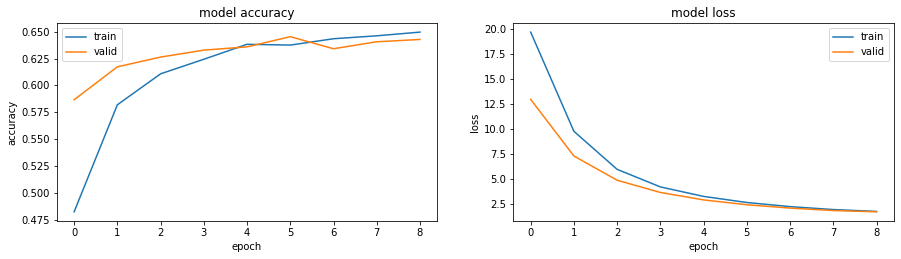


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.06523, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06523

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06523

Epoch 4: val_accuracy did not improve from 0.06523
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 29.5215 - accuracy: 0.0652

LOSS:	29.52145004272461 	 ACCURACY:	0.06522677838802338
[29.52145004272461, 0.06522677838802338]



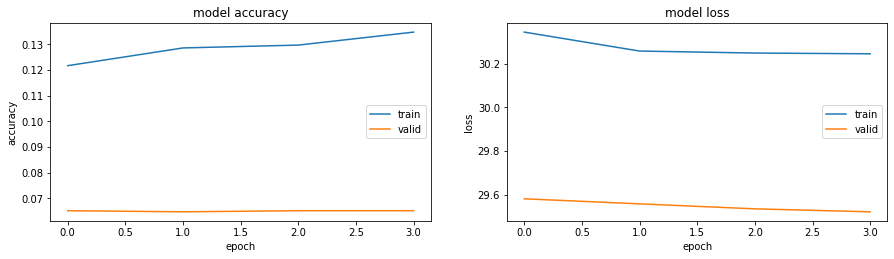


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.54730, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54730 to 0.55896, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.55896 to 0.56976, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.56976 to 0.58272, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.58272

Epoch 6: val_accuracy improved from 0.58272 to 0.59050, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.59050

Epoch 8: val_accuracy improved from 0.59050 to 0.59698, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59698 to 0.60734, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.60734

Epoch 11: val_accuracy improved from 0.60734 to 0.61555, saving model to DR.h5

Epoch 12: val_accuracy did not improve f

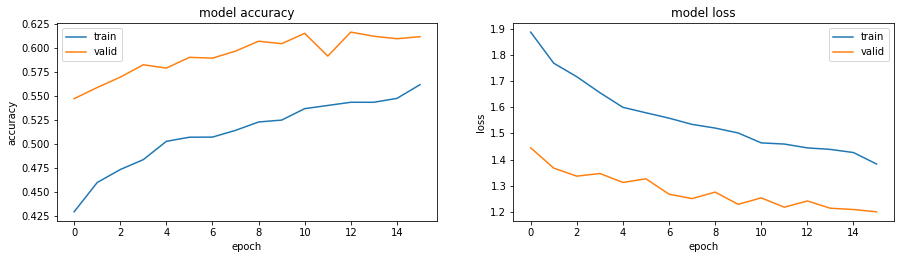


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.55119, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55119 to 0.59870, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59870 to 0.62376, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62376

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62376

Epoch 6: val_accuracy improved from 0.62376 to 0.63758, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63758

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.63758

Epoch 9: val_accuracy improved from 0.63758 to 0.64060, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64060

Epoch 11: ReduceLROn

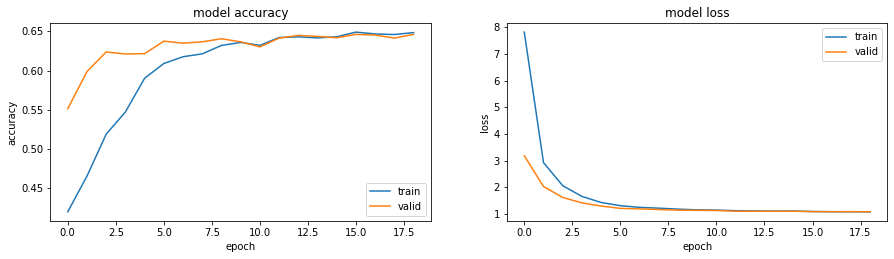


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 3.0e+00 5.0e-01 3.2e+01 1.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.53477, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53477 to 0.54384, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54384 to 0.54773, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54773 to 0.55335, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55335 to 0.56674, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56674 to 0.56760, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56760 to 0.57495, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57495 to 0.58272, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.58272

Epoch 10: val_accuracy improved from 0.58272 to 0.59525, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59525 to 0.59957, saving model to 

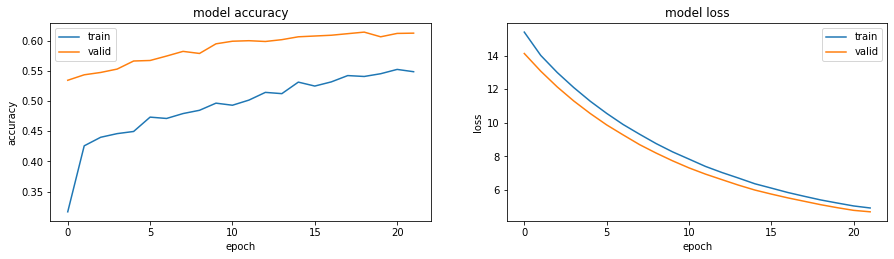


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 2.0e+00 3.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.47905, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.47905 to 0.52657, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52657 to 0.53650, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53650 to 0.53996, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53996 to 0.56371, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56371 to 0.57149, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57149 to 0.57581, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57581 to 0.58315, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.58315

Epoch 10: val_accuracy improved from 0.58315 to 0.59482, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59482 to 0.59827, saving model to 

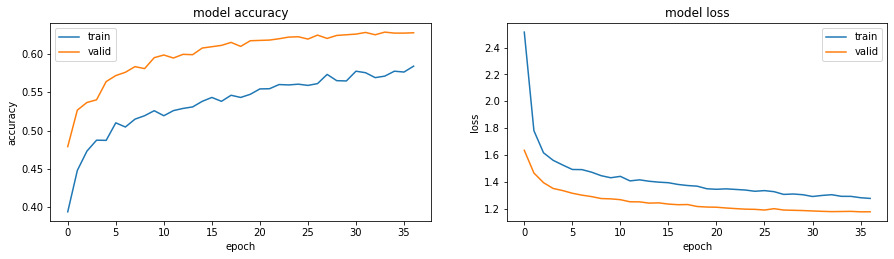


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.56544, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56544 to 0.60778, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.60778

Epoch 4: val_accuracy improved from 0.60778 to 0.62981, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62981

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.62981

Epoch 7: val_accuracy improved from 0.62981 to 0.63629, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63629

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.63629

Epoch 10: val_accuracy did not improve from 0.63629
Epoch 10: early stopping
73/73 [================

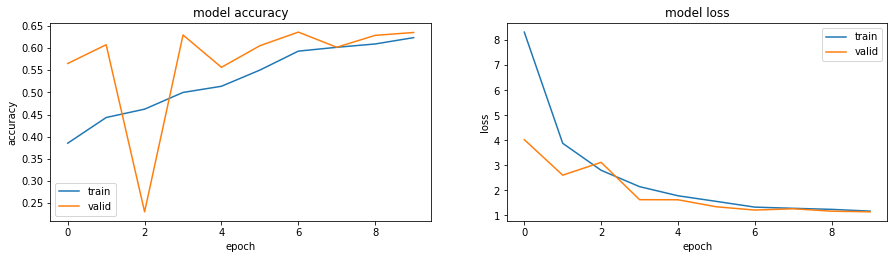


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.06695, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.06695 to 0.06911, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.06911 to 0.07257, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.07257 to 0.07732, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.07732 to 0.09201, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.09201 to 0.11404, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.11404 to 0.14773, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.14773 to 0.20950, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.20950 to 0.26566, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.26566 to 0.33261, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

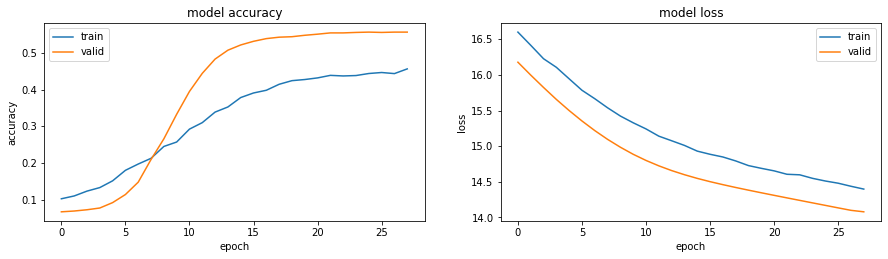


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.54989, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54989 to 0.57279, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57279 to 0.58186, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.58186 to 0.58402, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.58402 to 0.59093, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59093 to 0.59309, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.59309

Epoch 8: val_accuracy improved from 0.59309 to 0.59741, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59741 to 0.59827, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59827 to 0.60518, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.60518

Epoch 12: val

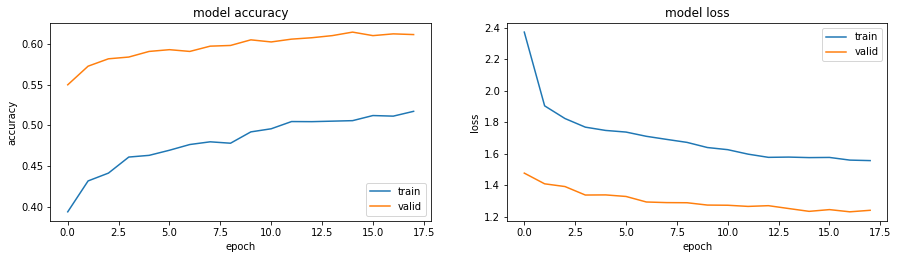


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-03 2.0e+00 3.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.59870, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59870 to 0.61469, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61469 to 0.62419, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62419

Epoch 5: val_accuracy improved from 0.62419 to 0.62808, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62808

Epoch 7: val_accuracy improved from 0.62808 to 0.63369, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63369 to 0.64795, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.64795

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.64795

Epoch 11: val_accuracy improved from 0.64795 to 0.65356, saving model to DR.

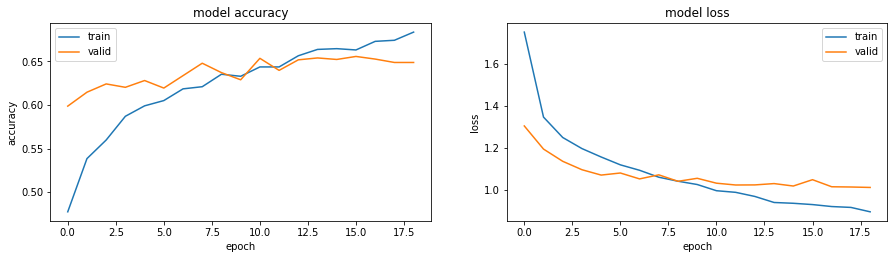


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 3.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.46998, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.46998 to 0.52613, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52613 to 0.53607, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53607 to 0.55594, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55594 to 0.55896, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.55896 to 0.56717, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.56717

Epoch 8: val_accuracy improved from 0.56717 to 0.57451, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.57451 to 0.57754, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.57754 to 0.58056, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.58056 to 0.58704, saving model to 

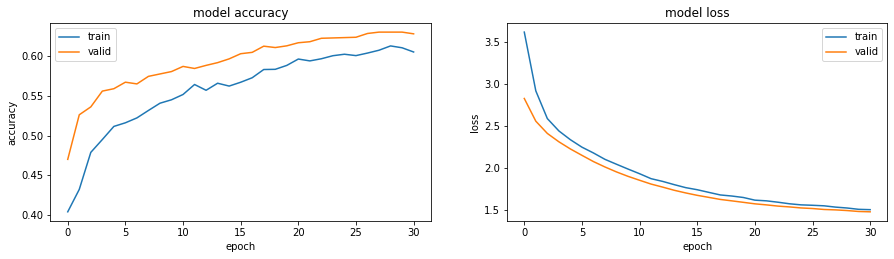


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.46177, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.46177 to 0.46955, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.46955 to 0.50713, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.50713

Epoch 5: val_accuracy improved from 0.50713 to 0.52700, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.52700

Epoch 7: val_accuracy improved from 0.52700 to 0.53218, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53218 to 0.54471, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54471 to 0.55292, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.55292

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve fro

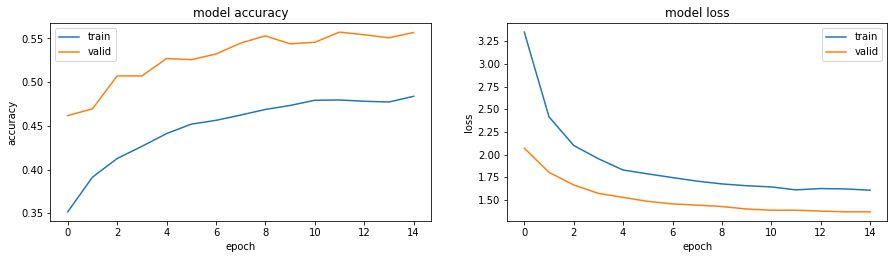


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 1.0e+00 5.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.20864, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.20864 to 0.36328, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.36328 to 0.44320, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.44320 to 0.47171, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.47171 to 0.48467, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.48467 to 0.49028, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.49028

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 8: val_accuracy did not improve from 0.49028

Epoch 9: val_accuracy did not improve from 0.49028
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 3.0961 - accuracy: 0.4825

LOSS:	3.09607243537

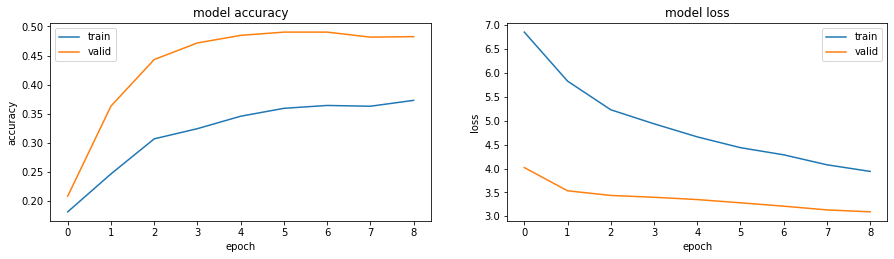


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.52657, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.52657

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.52657

Epoch 4: val_accuracy did not improve from 0.52657
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2.7230 - accuracy: 0.5218

LOSS:	2.722980499267578 	 ACCURACY:	0.521814227104187
[2.722980499267578, 0.521814227104187]



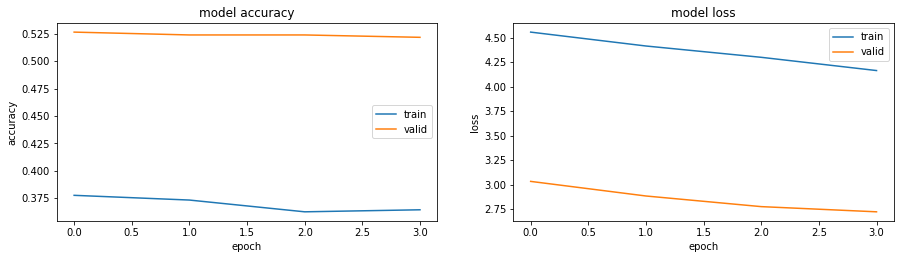


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.53434, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53434 to 0.54168, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54168 to 0.54989, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54989 to 0.56371, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.56371 to 0.57019, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.57019 to 0.57235, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57235 to 0.57883, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57883 to 0.58618, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58618 to 0.59266, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59266 to 0.59698, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

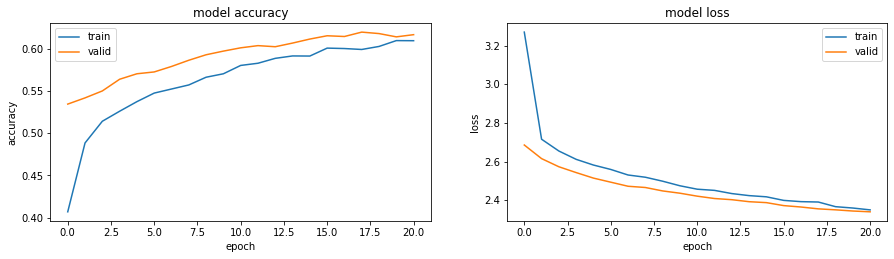


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.50108, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50108 to 0.54082, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54082 to 0.55119, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.55119 to 0.55551, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.55551

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.55551

Epoch 7: val_accuracy did not improve from 0.55551
Epoch 7: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 2.5235 - accuracy: 0.5555

LOSS:	2.52345871925354 	 ACCURACY:	0.5555075407028198
[2.52345871925354, 0.5555075407028198]



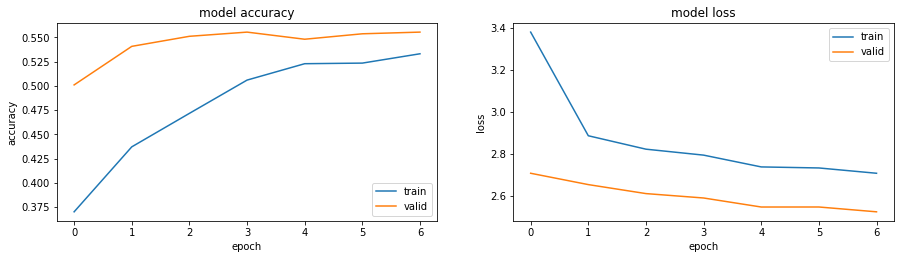


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.17235, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.17235 to 0.18488, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.18488 to 0.19957, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.19957 to 0.21296, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.21296 to 0.23542, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.23542 to 0.25875, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.25875 to 0.28510, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.28510 to 0.31447, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.31447 to 0.33693, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.33693 to 0.35767, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

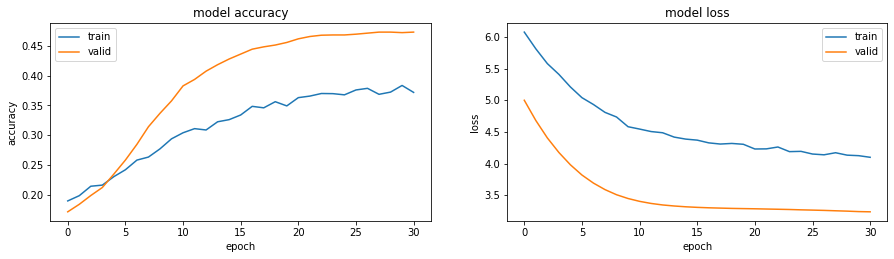


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.15680, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.15680 to 0.20864, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.20864 to 0.29287, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.29287 to 0.37711, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.37711 to 0.42419, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.42419 to 0.45443, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.45443 to 0.47214, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.47214 to 0.48769, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.48769 to 0.49633, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.49633 to 0.50583, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

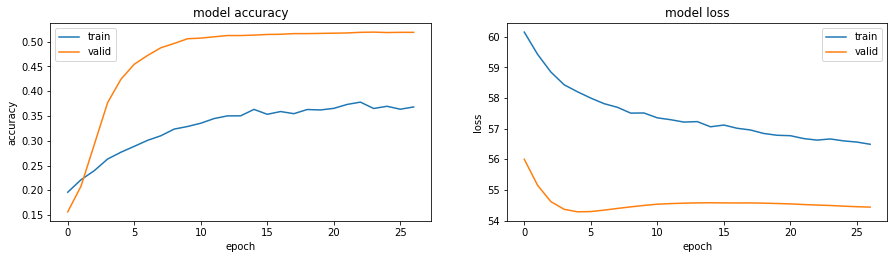


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 2.0e+00 3.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.58488, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58488 to 0.61123, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61123 to 0.61641, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.61641 to 0.62549, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62549 to 0.63456, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63456

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.63456

Epoch 8: val_accuracy did not improve from 0.63456
Epoch 8: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 7.2972 - accuracy: 0.6324

LOSS:	7.297206401824951 	 ACCURACY:	0.6323974132537842
[7.297206401824951, 0.6323974132537842]



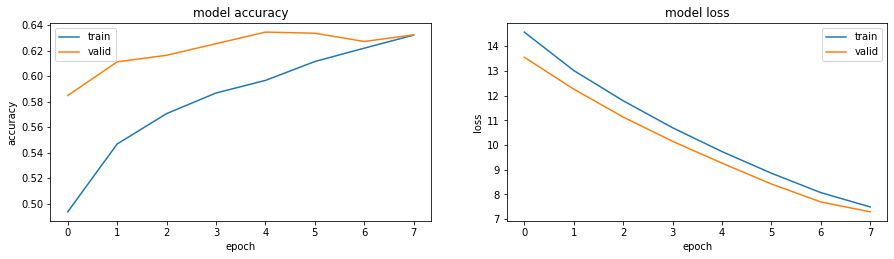


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 2.0e+00 5.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.58834, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58834 to 0.59222, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59222 to 0.62203, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62203

Epoch 5: val_accuracy improved from 0.62203 to 0.62808, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62808

Epoch 7: val_accuracy improved from 0.62808 to 0.63844, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63844

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.63844

Epoch 10: val_accuracy improved from 0.63844 to 0.64406, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64406

Epoch 12: val_accuracy i

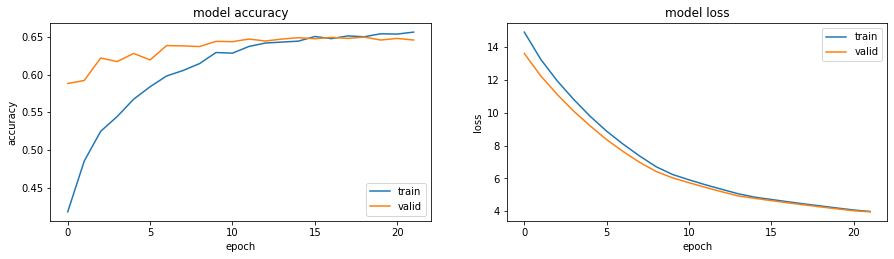


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.52570, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52570 to 0.52786, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52786 to 0.52959, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.52959

Epoch 5: val_accuracy improved from 0.52959 to 0.53175, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.53175

Epoch 7: val_accuracy improved from 0.53175 to 0.53391, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53391 to 0.53521, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.53521

Epoch 10: val_accuracy improved from 0.53521 to 0.53607, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.53607 to 0.53823, saving model to DR.h5

Epoch 12: val_accuracy improved from 0.5

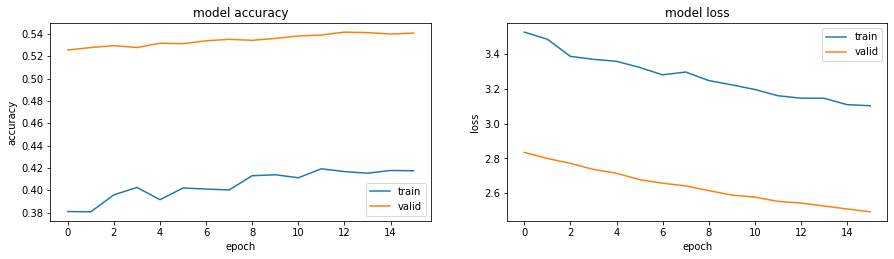


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.56242, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56242 to 0.59654, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59654 to 0.62073, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62073 to 0.62203, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62203 to 0.62894, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62894

Epoch 7: val_accuracy improved from 0.62894 to 0.63542, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63542

Epoch 9: val_accuracy improved from 0.63542 to 0.63844, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.63844 to 0.64060, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64060

Epoch 12: ReduceLROnPlateau reducing lea

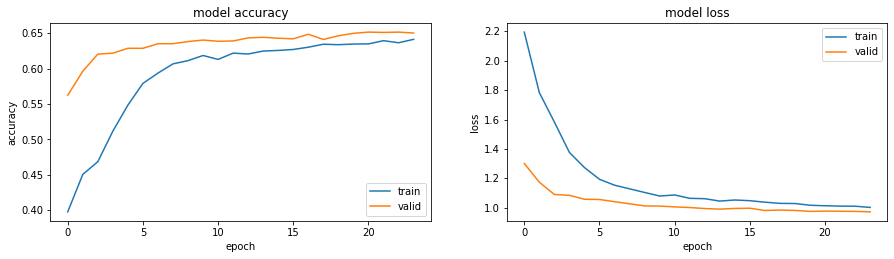


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.52657, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52657 to 0.53305, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53305 to 0.53693, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53693 to 0.53823, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53823 to 0.54082, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54082 to 0.54125, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54125 to 0.54428, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54428 to 0.54903, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54903 to 0.55119, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.55119 to 0.55292, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

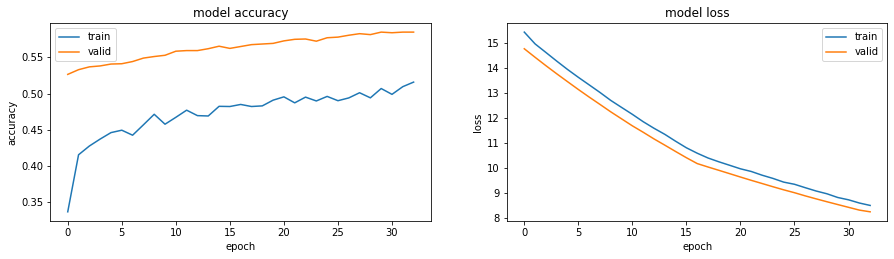


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.0665 - accuracy: 0.6505

Epoch 1: val_accuracy improved from -inf to 0.55292, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55292 to 0.59222, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59222

Epoch 4: val_accuracy improved from 0.59222 to 0.62678, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62678 to 0.63283, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63283

Epoch 7: val_accuracy improved from 0.63283 to 0.63801, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63801

Epoch 9: val_accuracy improved from 0.63801 to 0.64060, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64060 to 0.64795, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64795

Epoch 12: val_accuracy improved from 0.64795 to 0.64838, saving mod

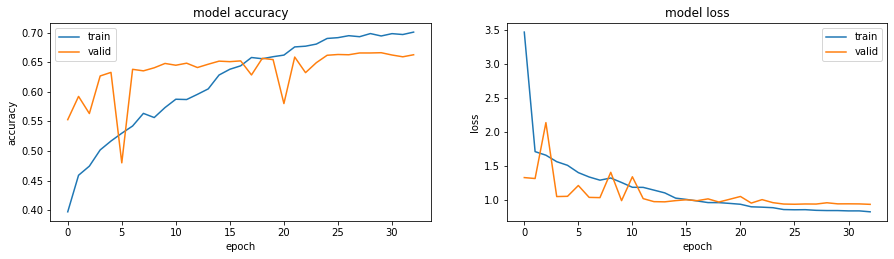


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.39136, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.39136 to 0.46566, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.46566 to 0.50626, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.50626 to 0.52052, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.52052 to 0.52700, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.52700 to 0.52873, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52873 to 0.53132, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53132 to 0.53305, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53305 to 0.53521, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.53521

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-

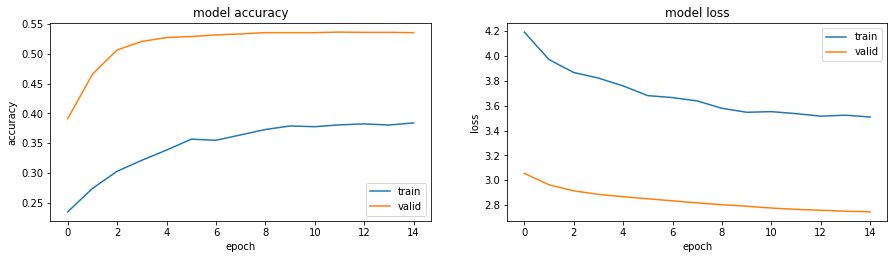


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.45184, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.45184 to 0.47689, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47689 to 0.49546, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.49546

Epoch 5: val_accuracy improved from 0.49546 to 0.50670, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50670 to 0.51490, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51490 to 0.51965, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.51965 to 0.52700, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52700 to 0.53909, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53909 to 0.54428, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.54428 to 0.54557, saving mo

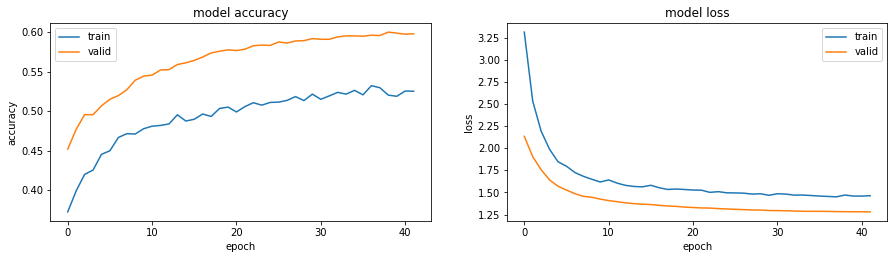


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.54514

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.54514

Epoch 4: val_accuracy improved from 0.54514 to 0.56415, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.56415 to 0.58704, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.58704

Epoch 7: val_accuracy improved from 0.58704 to 0.60389, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.60389

Epoch 9: val_accuracy improved from 0.60389 to 0.61987, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61987 to 0.62073, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.62073

Epoch 12: val_acc

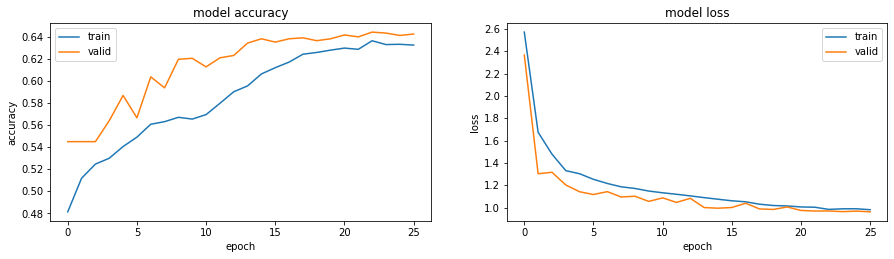


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.13607, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.13607 to 0.15248, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.15248 to 0.17192, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.17192 to 0.19093, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.19093 to 0.21512, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.21512 to 0.24708, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.24708 to 0.28121, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.28121 to 0.32311, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.32311 to 0.35594, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.35594 to 0.38359, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

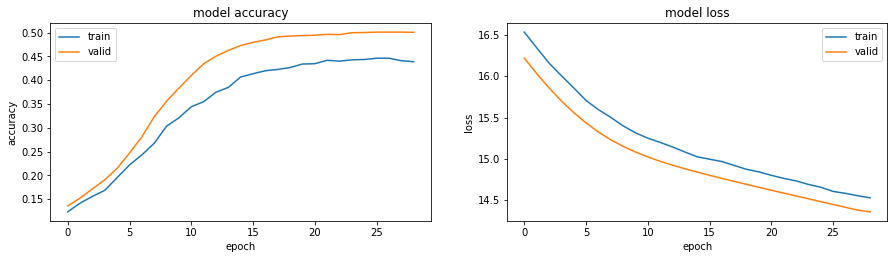


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54687, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54687 to 0.56847, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56847 to 0.57365, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.57365 to 0.59006, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59006 to 0.59611, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59611 to 0.60000, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60000 to 0.60043, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60043 to 0.60259, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.60259 to 0.60864, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.60864

Epoch 11: val_accuracy improved from 0.60864 to 0.61296, saving mo

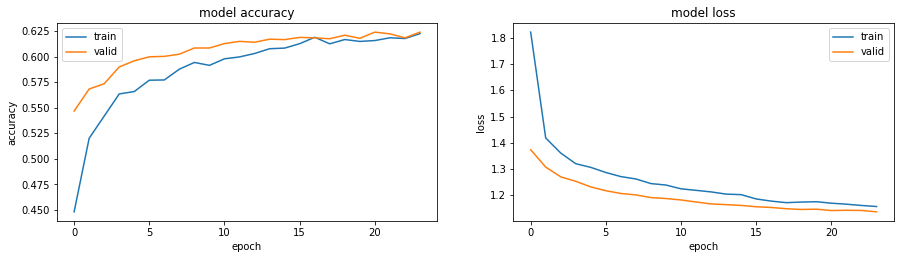


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.18920, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18920

Epoch 3: val_accuracy improved from 0.18920 to 0.18963, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.18963

Epoch 5: val_accuracy improved from 0.18963 to 0.19093, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.19093

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 7: val_accuracy did not improve from 0.19093

Epoch 8: val_accuracy improved from 0.19093 to 0.19222, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.19222 to 0.19525, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.19525 to 0.19870, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.19870

Epoch 12: val_acc

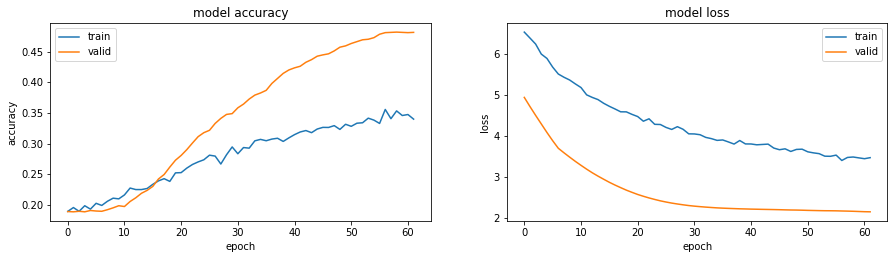


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 3.0e+00 5.0e-01 3.2e+01 1.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54600, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54600 to 0.56069, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.56069

Epoch 4: val_accuracy improved from 0.56069 to 0.57322, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.57322 to 0.58229, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.58229 to 0.59179, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.59179

Epoch 8: val_accuracy improved from 0.59179 to 0.59654, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.59654

Epoch 10: val_accuracy improved from 0.59654 to 0.59957, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59957 to 0.60259, saving model to DR.h5

Epoch 12: val_accuracy did not improve from 0.6

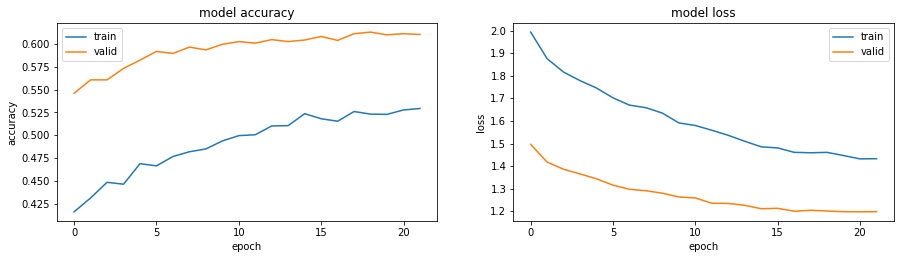


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.32009, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.32009 to 0.33823, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.33823 to 0.36415, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.36415 to 0.39179, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.39179 to 0.40994, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.40994 to 0.43369, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.43369 to 0.45270, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.45270 to 0.46868, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.46868 to 0.47948, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.47948 to 0.49158, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

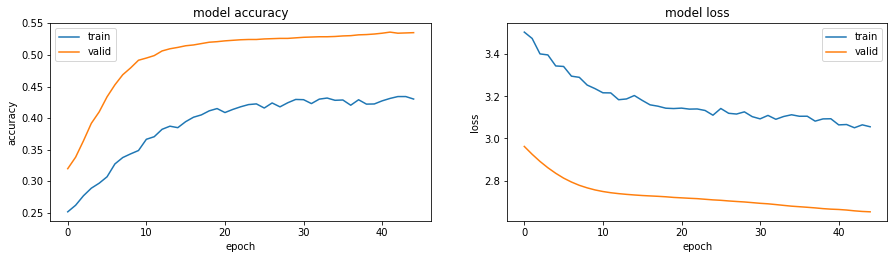


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.55421, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55421 to 0.57927, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57927 to 0.59266, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.59266

Epoch 5: val_accuracy improved from 0.59266 to 0.61425, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61425 to 0.62246, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62246 to 0.62505, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.62505

Epoch 9: val_accuracy improved from 0.62505 to 0.62678, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.62678

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve fro

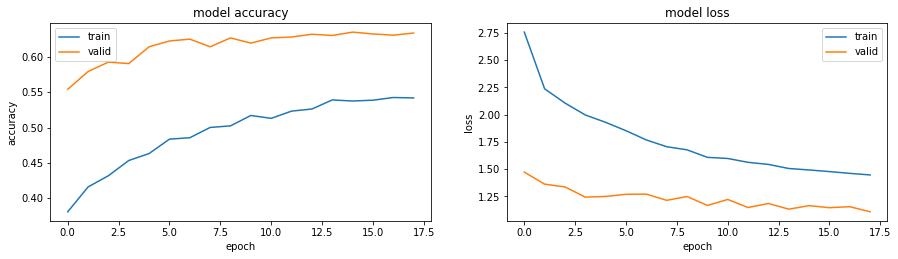


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 1.0e+00 5.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.19136, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.19136 to 0.20778, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.20778 to 0.26782, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.26782 to 0.35335, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.35335 to 0.41123, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.41123 to 0.44924, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.44924 to 0.46091, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.46091 to 0.46868, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.46868 to 0.47171, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.47171 to 0.47603, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.

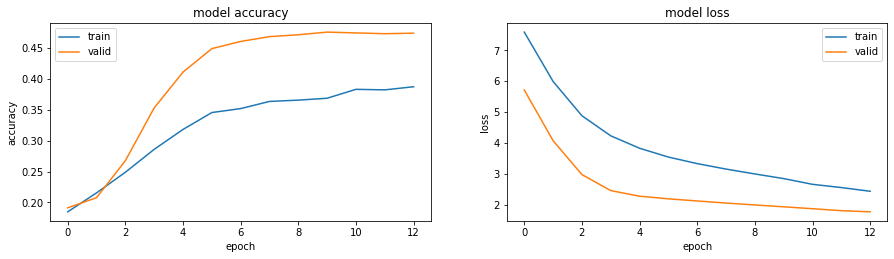


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53564, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53564 to 0.54255, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.54255

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.54255

Epoch 5: val_accuracy did not improve from 0.54255
Epoch 5: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 14.8591 - accuracy: 0.5413

LOSS:	14.859081268310547 	 ACCURACY:	0.5412526726722717
[14.859081268310547, 0.5412526726722717]



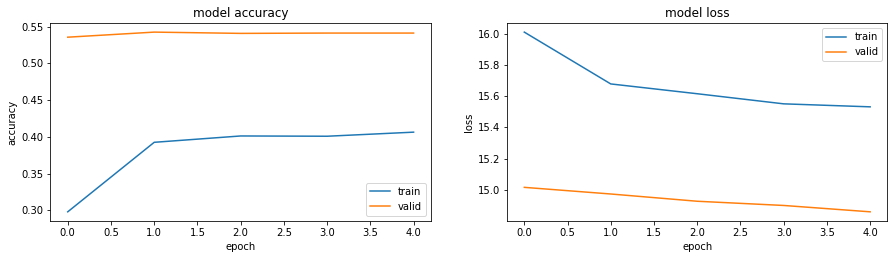


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.55421, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55421 to 0.57538, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57538 to 0.58272, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.58272 to 0.60302, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.60302 to 0.61296, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61296 to 0.62203, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62203

Epoch 8: val_accuracy improved from 0.62203 to 0.62462, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.62462

Epoch 10: val_accuracy improved from 0.62462 to 0.62894, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.62894

Epoch 12: val_accuracy improved from 0.6

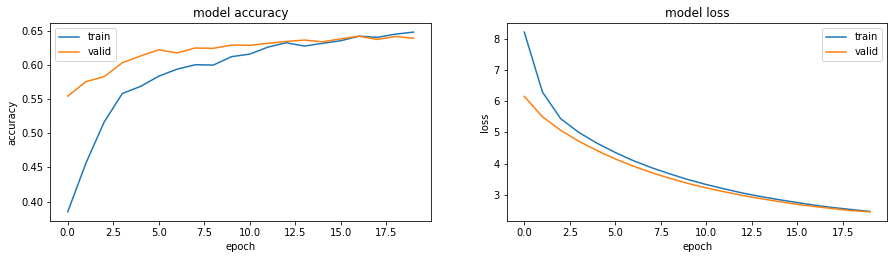


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.12268, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12268 to 0.21339, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.21339 to 0.30842, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.30842 to 0.39482, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.39482 to 0.44708, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.44708 to 0.48164, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.48164 to 0.50410, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.50410 to 0.51793, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.51793 to 0.52441, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.52441 to 0.52743, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

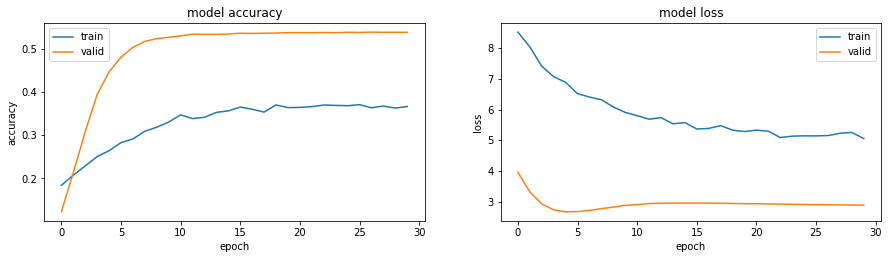


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53175, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53175 to 0.54773, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54773 to 0.56112, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.56112 to 0.57883, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.57883 to 0.58747, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.58747 to 0.60173, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60173 to 0.60691, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60691 to 0.60994, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.60994 to 0.61166, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61166 to 0.61814, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

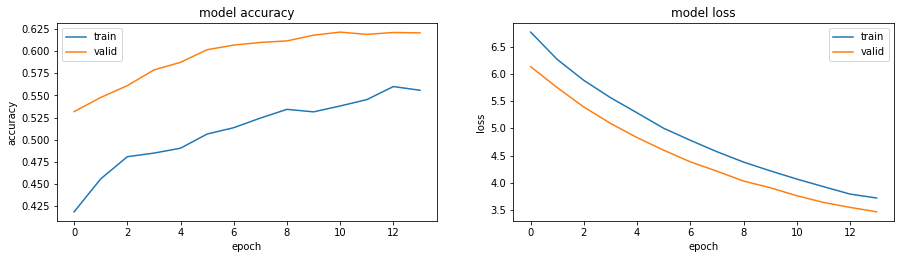


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.08812, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.08812 to 0.09374, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.09374 to 0.10151, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.10151 to 0.10410, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.10410 to 0.10842, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.10842 to 0.11404, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.11404 to 0.12181, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.12181 to 0.12873, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.12873 to 0.13305, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.13305 to 0.14514, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

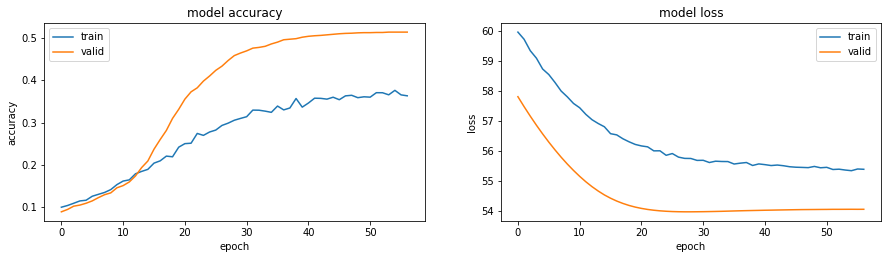


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 1.0e+00 3.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.35248, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.35248 to 0.43888, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.43888 to 0.45702, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.45702 to 0.45788, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.45788 to 0.46004, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.46004 to 0.46695, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.46695 to 0.47214, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.47214 to 0.48294, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.48294 to 0.48467, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.48467 to 0.48553, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.48553 t

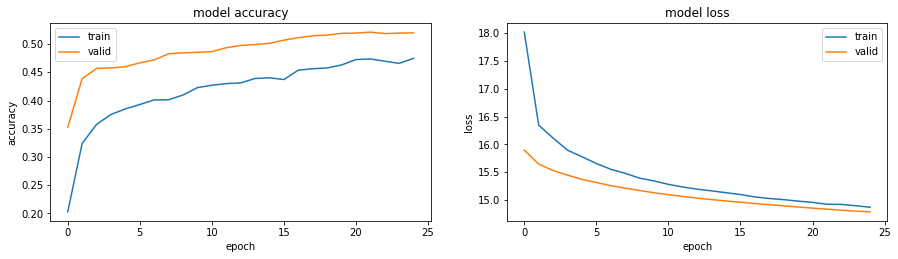


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.56285, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56285 to 0.58747, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.58747 to 0.60432, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.60432 to 0.62635, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62635

Epoch 6: val_accuracy improved from 0.62635 to 0.62851, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62851 to 0.63197, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63197

Epoch 9: val_accuracy improved from 0.63197 to 0.64492, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64492

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve fro

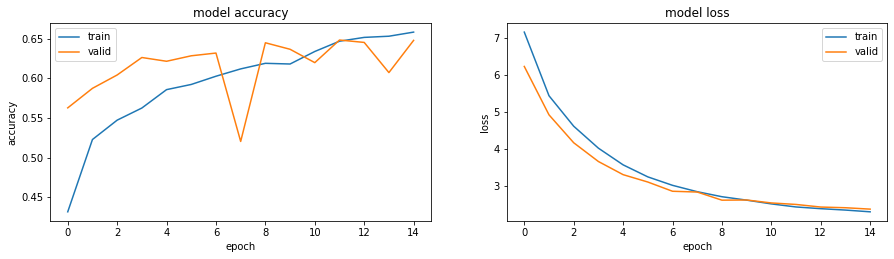


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.41339, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.41339 to 0.49719, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.49719 to 0.51361, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.51361 to 0.52786, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.52786 to 0.54514, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54514 to 0.55810, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55810 to 0.56328, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.56328

Epoch 9: val_accuracy improved from 0.56328 to 0.57667, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.57667 to 0.58056, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.58056

Epoch 12: Red

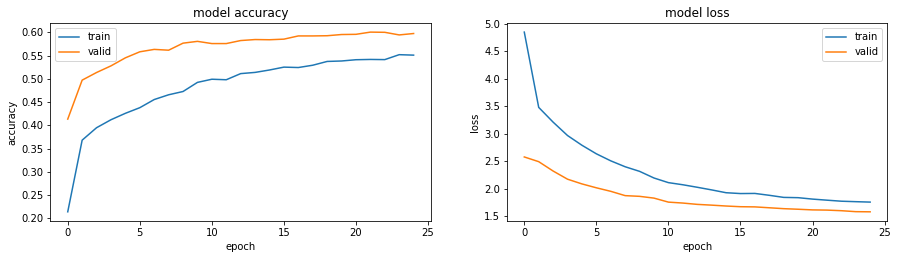


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.59179, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59179 to 0.61857, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61857 to 0.63585, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63585 to 0.63672, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63672

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.63672

Epoch 7: val_accuracy improved from 0.63672 to 0.64147, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.64147

Epoch 9: val_accuracy improved from 0.64147 to 0.64190, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64190 to 0.64363, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.6436

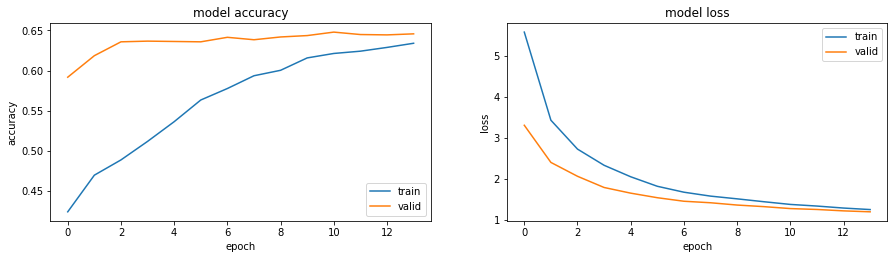


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.18661, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18661 to 0.18790, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.18790 to 0.18834, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.18834 to 0.18920, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.18920

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 6: val_accuracy did not improve from 0.18920

Epoch 7: val_accuracy did not improve from 0.18920
Epoch 7: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 10.1245 - accuracy: 0.1875

LOSS:	10.124469757080078 	 ACCURACY:	0.18747299909591675
[10.124469757080078, 0.18747299909591675]



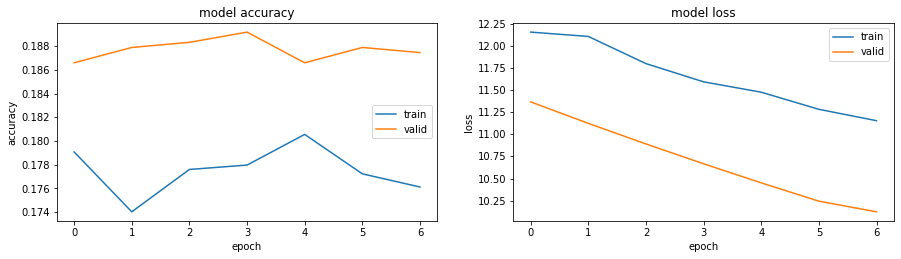


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 3.0e+00 3.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53045, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53045 to 0.53909, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53909 to 0.54125, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.54125

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.54125

Epoch 6: val_accuracy improved from 0.54125 to 0.54384, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54384 to 0.54557, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54557 to 0.54903, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54903 to 0.55032, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.55032 to 0.55205, saving model to DR.h5

Epoch 11: val_accuracy 

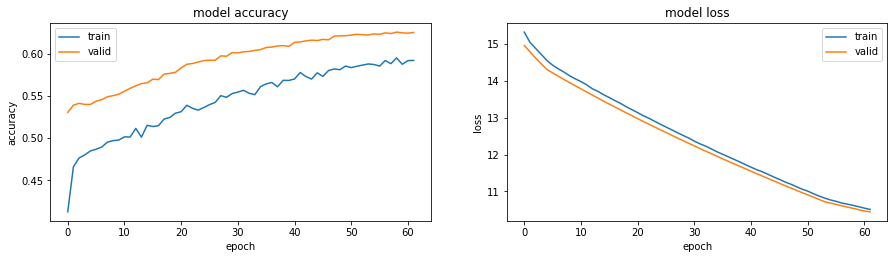


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 2.0e+00 7.0e-01 3.2e+01 3.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.59006, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59006 to 0.62376, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62376 to 0.63326, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.63326

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.63326

Epoch 6: val_accuracy improved from 0.63326 to 0.63844, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.63844 to 0.64536, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.64536

Epoch 9: val_accuracy improved from 0.64536 to 0.64752, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64752

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.


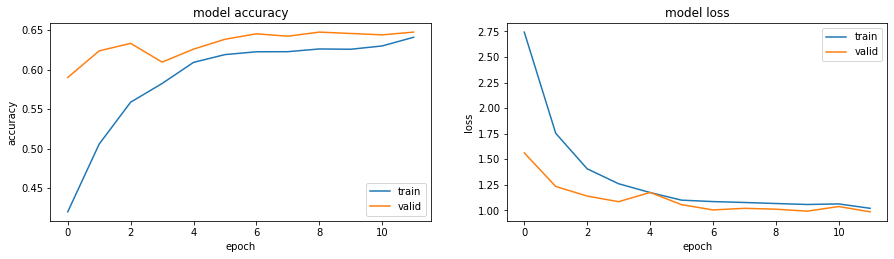


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.17797, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.17797 to 0.17883, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.17883 to 0.17970, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.17970 to 0.18056, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18056 to 0.18402, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.18402 to 0.18445, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.18445

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 8: val_accuracy did not improve from 0.18445

Epoch 9: val_accuracy did not improve from 0.18445
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 3.5574 - accuracy: 0.1832

LOSS:	3.5574

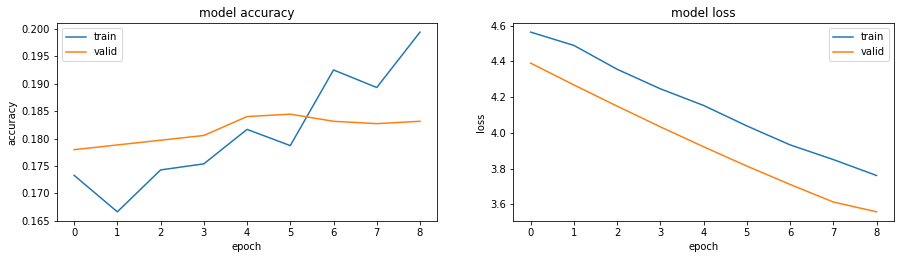


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.50065, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50065 to 0.53434, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53434 to 0.54255, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.54255

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.54255

Epoch 6: val_accuracy improved from 0.54255 to 0.54471, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54471 to 0.54600, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.54600

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.54600

Epoch 10: val_accuracy did not improve from 0.54600
Epoch 10: early stopp

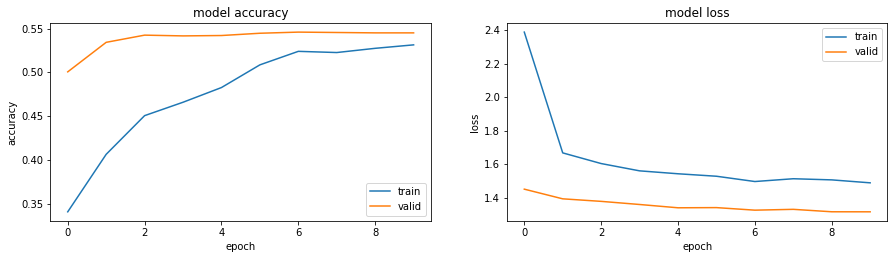


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53521, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53521 to 0.58013, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.58013 to 0.59611, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.59611 to 0.60432, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.60432 to 0.61080, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61080 to 0.61210, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61210 to 0.62030, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.62030 to 0.62333, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.62333 to 0.62851, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.62851 to 0.63413, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

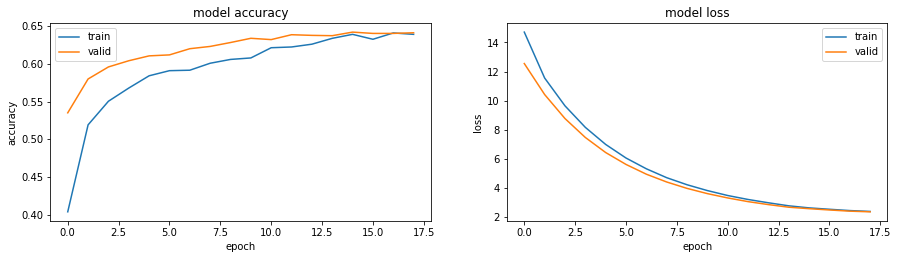


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53564, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53564 to 0.53823, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.53823

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.53823

Epoch 5: val_accuracy did not improve from 0.53823
Epoch 5: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.5538 - accuracy: 0.5365

LOSS:	1.553834080696106 	 ACCURACY:	0.5365011096000671
[1.553834080696106, 0.5365011096000671]



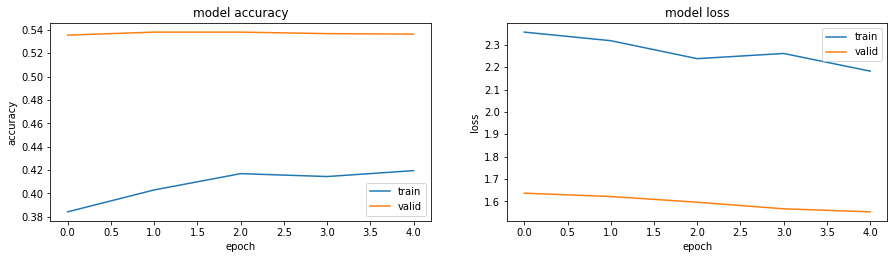


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.45918, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.45918 to 0.48035, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.48035 to 0.49374, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.49374 to 0.50281, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.50281 to 0.51145, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.51145 to 0.51490, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51490 to 0.52052, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52052 to 0.52354, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52354 to 0.52397, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.52397 to 0.52527, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

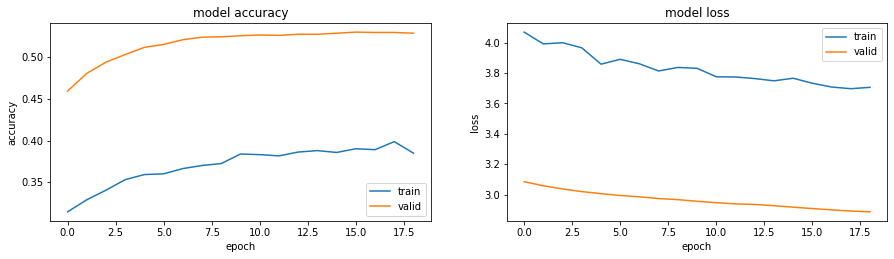


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.52225, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52225 to 0.52268, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52268 to 0.52613, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.52613 to 0.53132, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.53132

Epoch 6: val_accuracy improved from 0.53132 to 0.53391, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.53391 to 0.53434, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53434 to 0.53607, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53607 to 0.53737, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.53737

Epoch 11: val_accuracy improved from 0.53737 to 0.53823, saving model to DR.h5

Epoch 12: val

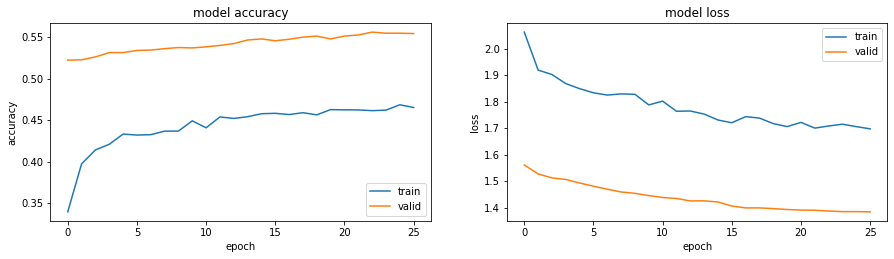


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54644, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54644 to 0.55896, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.55896 to 0.56890, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.56890 to 0.58229, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.58229 to 0.59395, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59395 to 0.59741, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.59741 to 0.60562, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60562 to 0.61210, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.61210 to 0.61512, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61512 to 0.61944, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

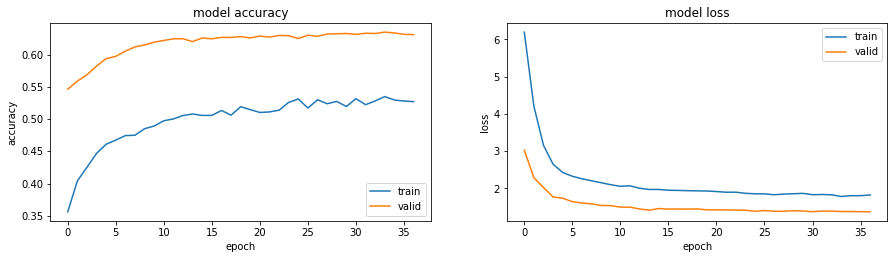


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.54514

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.54514

Epoch 4: val_accuracy improved from 0.54514 to 0.60950, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.60950

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 6: val_accuracy did not improve from 0.60950

Epoch 7: val_accuracy improved from 0.60950 to 0.61512, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.61512 to 0.63024, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63024

Epoch 10: val_accuracy improved from 0.63024 to 0.63197, saving model to DR.h5

Epoch 11: val_accura

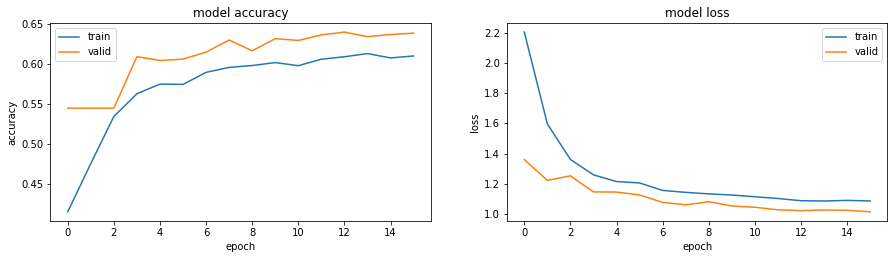


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.18531, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18531 to 0.32095, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.32095 to 0.43542, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.43542 to 0.49503, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.49503 to 0.51793, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.51793 to 0.52441, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52441 to 0.52570, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52570 to 0.52959, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52959 to 0.53218, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53218 to 0.53434, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

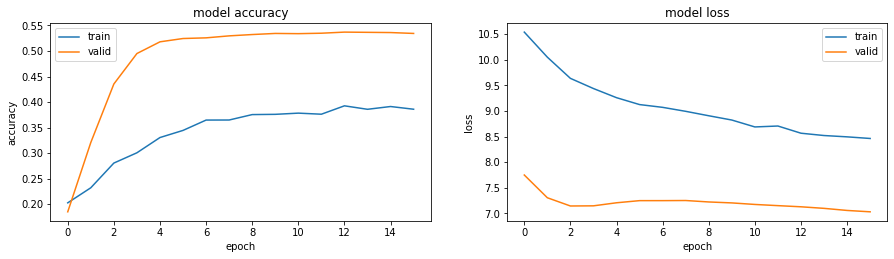


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.43456, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.43456 to 0.47171, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47171 to 0.48380, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.48380 to 0.49287, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.49287 to 0.50151, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.50151

Epoch 7: val_accuracy improved from 0.50151 to 0.50367, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.50367 to 0.50497, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.50497 to 0.50540, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.50540 to 0.50583, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.50583 to 0.51058, saving mo

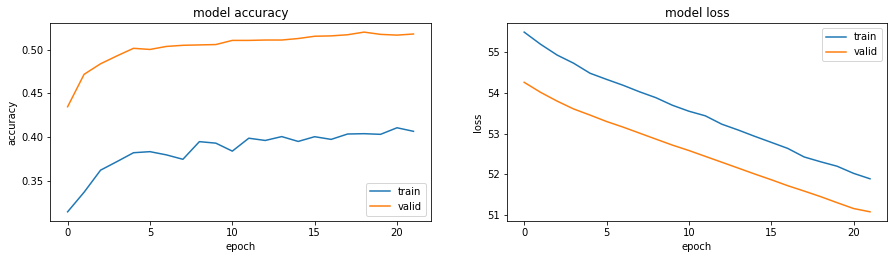


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.56717, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56717 to 0.59957, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59957

Epoch 4: val_accuracy improved from 0.59957 to 0.62549, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62549

Epoch 6: val_accuracy improved from 0.62549 to 0.63067, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.63067 to 0.63369, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63369

Epoch 9: val_accuracy improved from 0.63369 to 0.63629, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63629

Epoch 11: val_accuracy improved from 0.63629 to 0.63974, saving model to DR.h5

Epoch 12: val_accuracy improved from 0.63974 to 0.64190, saving mod

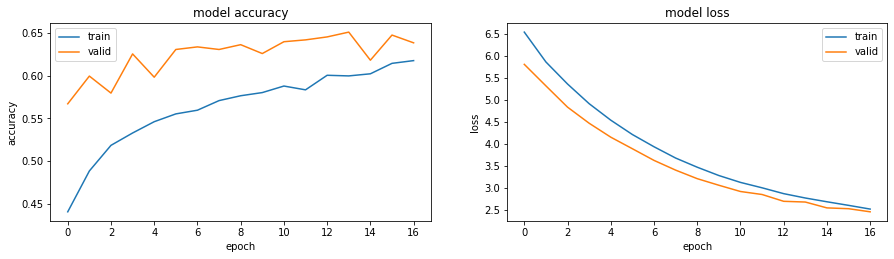


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.13952, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.13952 to 0.14298, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.14298 to 0.17149, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.17149 to 0.23758, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.23758 to 0.31836, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.31836 to 0.38661, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.38661 to 0.43024, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.43024 to 0.46436, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.46436 to 0.48553, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.48553 to 0.49676, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

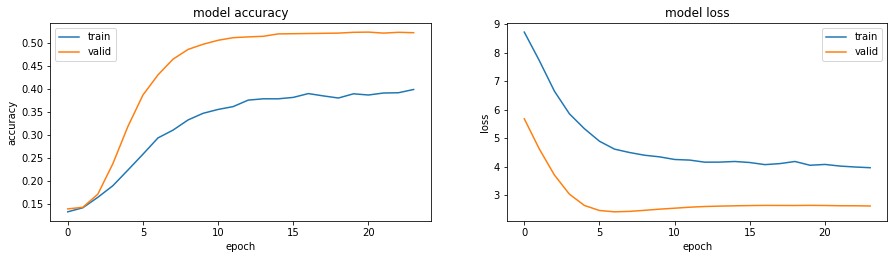


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.53477, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53477 to 0.54600, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54600 to 0.55767, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.55767 to 0.57235, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.57235 to 0.58359, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.58359 to 0.59222, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.59222 to 0.60302, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60302 to 0.60691, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.60691 to 0.60950, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.60950 to 0.61771, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

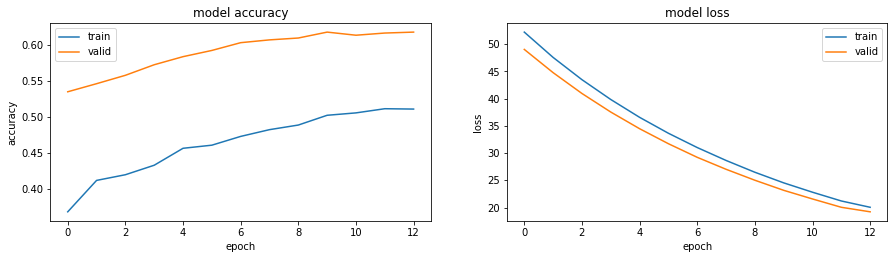


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.50713, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50713 to 0.52786, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52786 to 0.53261, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53261 to 0.53348, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.53348

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 6: val_accuracy did not improve from 0.53348

Epoch 7: val_accuracy did not improve from 0.53348
Epoch 7: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 7.3274 - accuracy: 0.5279

LOSS:	7.327367305755615 	 ACCURACY:	0.5278617739677429
[7.327367305755615, 0.5278617739677429]



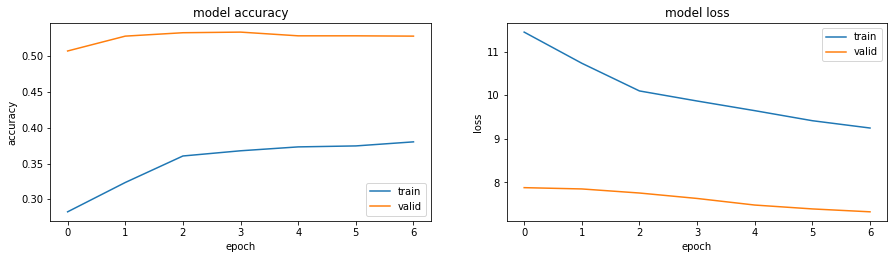


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.46955, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.46955 to 0.47257, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47257 to 0.50756, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.50756 to 0.51620, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.51620 to 0.53996, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53996 to 0.56285, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56285 to 0.56544, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.56544 to 0.58272, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.58272

Epoch 10: val_accuracy improved from 0.58272 to 0.58834, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.58834 to 0.59482, saving mo

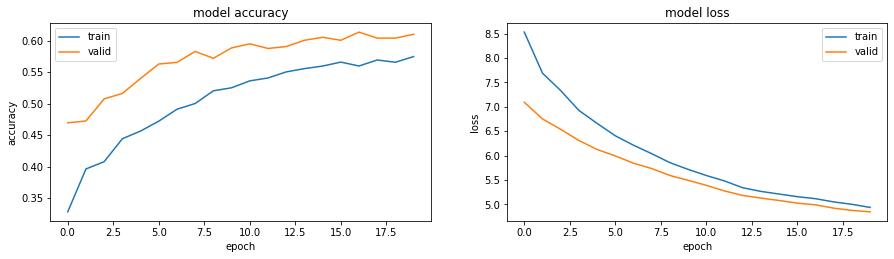


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.17451, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.17451 to 0.17797, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.17797

Epoch 4: val_accuracy improved from 0.17797 to 0.18186, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18186 to 0.18618, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.18618 to 0.18834, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.18834 to 0.19611, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.19611 to 0.20130, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.20130 to 0.21210, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.21210 to 0.21512, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.21512 to 0.22376, saving mo

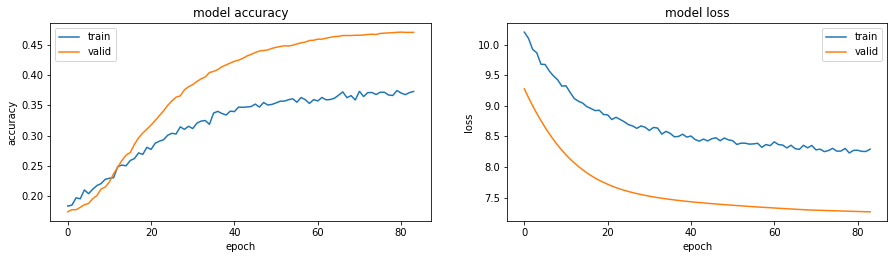


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 3.0e-01 3.2e+01 1.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.49849, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.49849 to 0.52743, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52743 to 0.53780, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53780 to 0.55421, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55421 to 0.56069, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56069 to 0.57063, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57063 to 0.57581, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.57581

Epoch 9: val_accuracy improved from 0.57581 to 0.58272, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.58272 to 0.58359, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.58359 to 0.59006, saving model to 

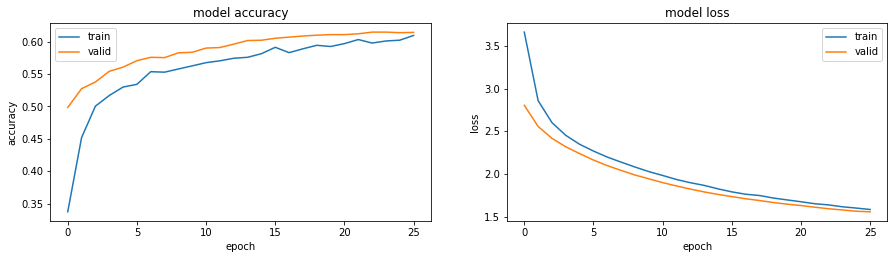


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.61598, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.61598 to 0.63629, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.63629

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.63629

Epoch 5: val_accuracy improved from 0.63629 to 0.64320, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64320

Epoch 7: val_accuracy improved from 0.64320 to 0.65097, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.65097

Epoch 9: val_accuracy improved from 0.65097 to 0.65659, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.65659

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 11: val_accur

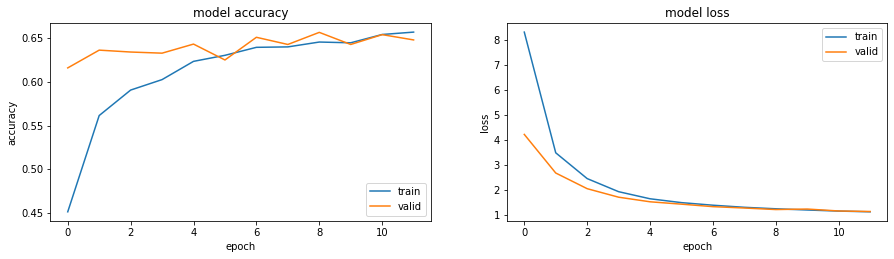


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 3.0e+00 3.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.36242, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.36242 to 0.48639, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.48639 to 0.52095, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.52095 to 0.52873, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.52873 to 0.53218, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53218 to 0.53477, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.53477 to 0.53607, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53607 to 0.53780, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53780 to 0.53823, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53823 to 0.53952, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.53952 t

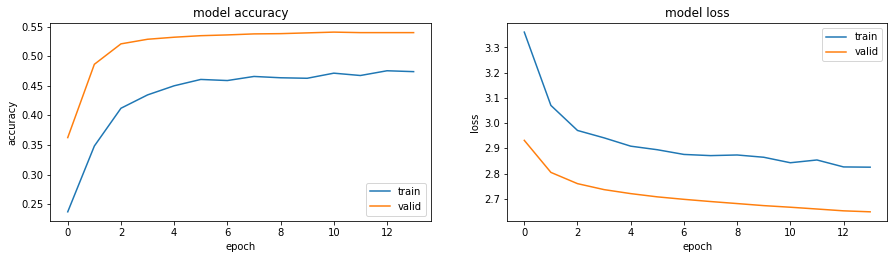


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.18531, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18531 to 0.31533, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.31533 to 0.45011, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.45011 to 0.49676, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.49676 to 0.50929, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50929 to 0.51361, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.51361

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.51361

Epoch 9: val_accuracy did not improve from 0.51361
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 14.2846 - accuracy: 0.5076

LOSS:	14.28

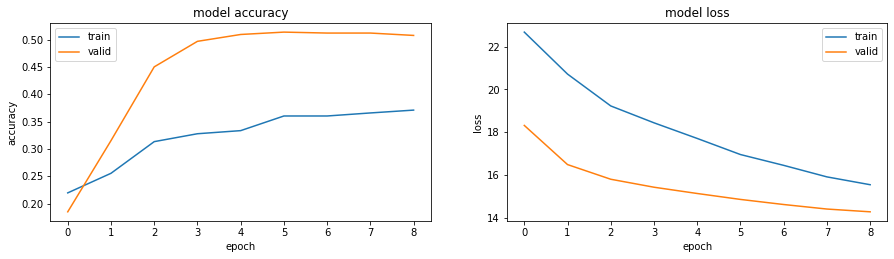


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54514 to 0.59266, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59266

Epoch 4: val_accuracy improved from 0.59266 to 0.61987, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.61987

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.61987

Epoch 7: val_accuracy improved from 0.61987 to 0.62549, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.62549 to 0.64060, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.64060

Epoch 10: val_accuracy improved from 0.64060 to 0.64579, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64579

Epoch 12: ReduceL

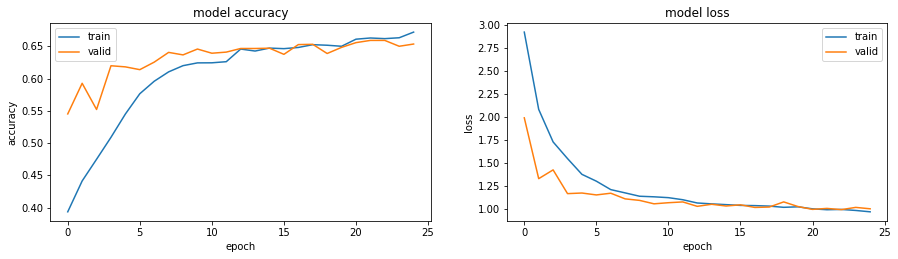


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-03 2.0e+00 7.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.47948, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.47948

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.47948

Epoch 4: val_accuracy did not improve from 0.47948
Epoch 4: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.9631 - accuracy: 0.4687

LOSS:	1.9631041288375854 	 ACCURACY:	0.46868249773979187
[1.9631041288375854, 0.46868249773979187]



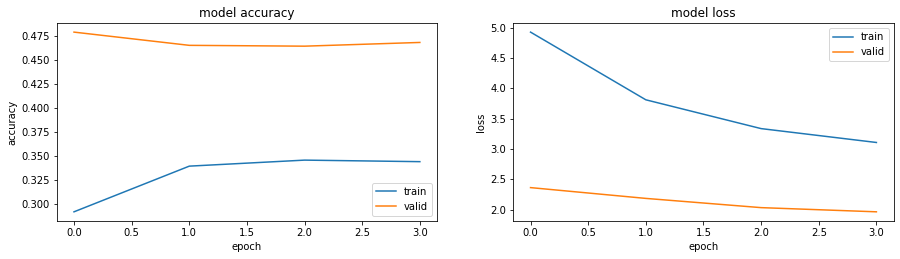


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 5.0e-01 3.2e+01 2.0e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.20389, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.20389 to 0.47084, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47084 to 0.48380, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.48380 to 0.48812, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.48812

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 6: val_accuracy did not improve from 0.48812

Epoch 7: val_accuracy did not improve from 0.48812
Epoch 7: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 2.8211 - accuracy: 0.4825

LOSS:	2.821065902709961 	 ACCURACY:	0.4825054109096527
[2.821065902709961, 0.4825054109096527]



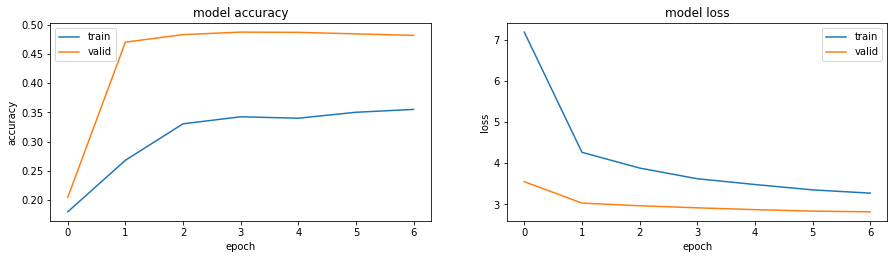


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.21685, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.21685 to 0.43067, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.43067 to 0.51361, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.51361 to 0.53261, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53261 to 0.53607, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.53607

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 7: val_accuracy did not improve from 0.53607

Epoch 8: val_accuracy did not improve from 0.53607
Epoch 8: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.9682 - accuracy: 0.5352

LOSS:	1.9681756496429443 	 ACCURACY:	0.5352051854133606
[1.9681756496429443, 0.535205185413

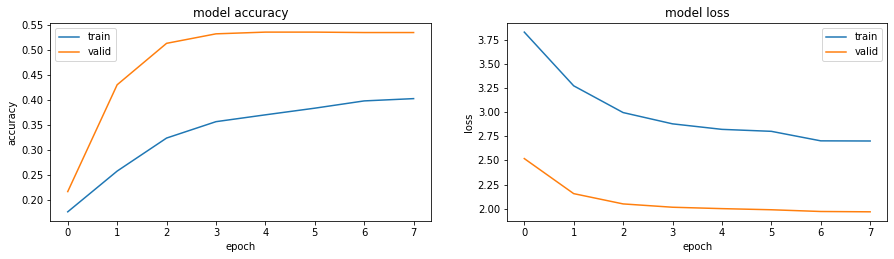


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.60432, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60432 to 0.62505, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62505 to 0.63456, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.63456

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.63456

Epoch 6: val_accuracy did not improve from 0.63456
Epoch 6: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.2784 - accuracy: 0.6346

LOSS:	1.2784252166748047 	 ACCURACY:	0.6345572471618652
[1.2784252166748047, 0.6345572471618652]



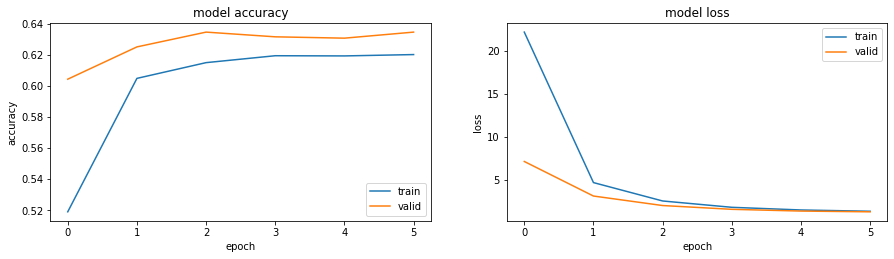


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.09374, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.09374 to 0.15810, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.15810 to 0.31490, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.31490 to 0.44147, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.44147 to 0.48898, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.48898 to 0.51058, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51058 to 0.51793, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.51793 to 0.51879, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.51879 to 0.52397, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.52397

Epoch 11: val_accuracy improved from 0.52397 to 0.52484, saving mo

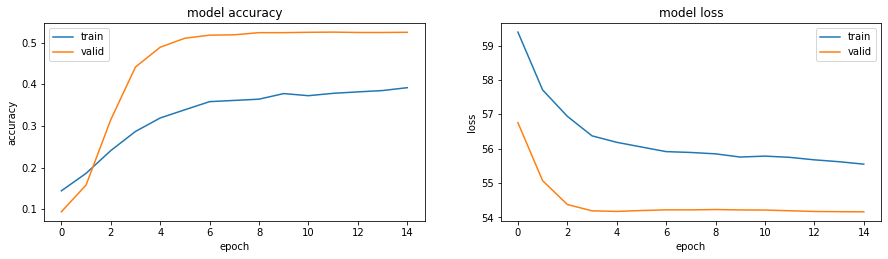


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.61210, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.61210 to 0.62808, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62808 to 0.63715, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63715 to 0.64104, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.64104 to 0.64233, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.64233 to 0.64881, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64881

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.64881

Epoch 9: val_accuracy improved from 0.64881 to 0.65313, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.65313 to 0.65616, saving model to DR.h5

Epoch 11: val_ac

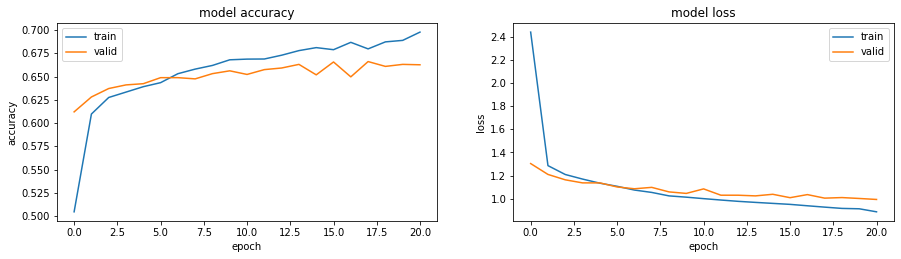


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.12052, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12052 to 0.13261, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.13261 to 0.15551, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.15551 to 0.18790, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18790 to 0.21944, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.21944 to 0.26695, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.26695 to 0.30151, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.30151 to 0.34384, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.34384 to 0.38575, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.38575 to 0.42289, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

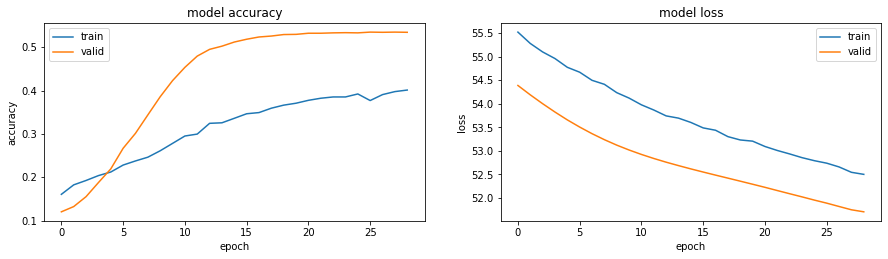


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.54989, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54989 to 0.57754, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57754 to 0.57883, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.57883 to 0.57970, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.57970 to 0.58877, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.58877 to 0.59136, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.59136 to 0.59352, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.59352 to 0.59568, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59568 to 0.60000, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.60000 to 0.60302, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

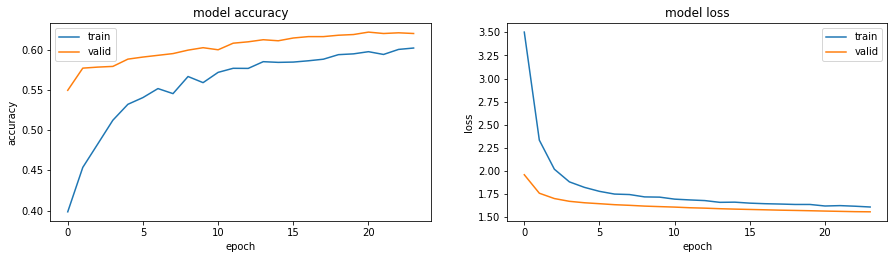


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 0.9380 - accuracy: 0.6626

Epoch 1: val_accuracy improved from -inf to 0.51836, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51836 to 0.53348, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53348 to 0.53391, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53391 to 0.53693, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53693 to 0.53909, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.53909

Epoch 7: val_accuracy improved from 0.53909 to 0.54168, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54168 to 0.54341, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54341 to 0.54773, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54773 to 0.54903, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.54903 to 0.55119, saving mo

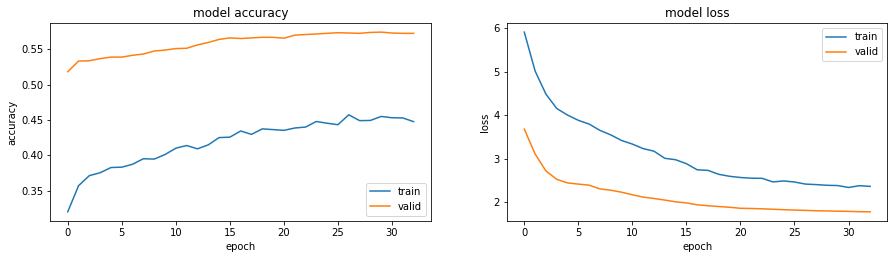

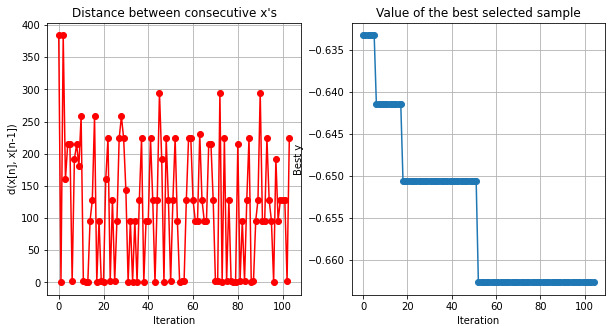

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	64.0
	learning_rate:	0.001
	l2:	0.001
	activation:	elu
	rate:	0.5
	batch:	256.0
 optim RMSprop
optimized accuracy: [0.66263497]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

In [ ]:
best_model.evaluate(features_valid, y_test)

73/73 [==============================] - 0s 3ms/step - loss: 0.9380 - accuracy: 0.6626


[0.9380363821983337, 0.6626349687576294]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))

LOSS:	1.4783755540847778 	 ACCURACY:	0.0 	 PRECISION:	0.5458477735519409 	 RECALL:	0.5458477735519409 	 F1-SCORE:	0.14124231040477753


In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Mon May 30 14:56:14 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           1336.9384410381317 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

In [ ]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [ ]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

37/37 [==============================] - 0s 3ms/step - loss: 0.8788 - accuracy: 0.6922
Restored model, accuracy: 69.22%


In [ ]:
best_model.evaluate(features_test, y_test)

37/37 [==============================] - 0s 3ms/step - loss: 0.8788 - accuracy: 0.6922


[0.8788230419158936, 0.6921753883361816]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))